# Tutoriel 3 : ImageNet et  Transfert d'apprentissage
***INF889G - Vision par ordinateur (UQÀM)***

Adapté du [tutoriel 3](https://colab.research.google.com/drive/1EBz4feoaUvz-o_yeMI27LEQBkvrXNc_4#scrollTo=X7IHgrsqd-W0) du cours CSE455 à l'Université de Washington (J. Redmon).

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joe-from-mtl/teaching/blob/main/notebooks/inf889g-vision/tuto3_imagenet_transfert.ipynb)

Dans ce tutoriel, nous entraînerons un modèle avec le jeu de données [ImageNet](http://www.image-net.org/). Malheureusement, on ne peut pas entraîner avec la version complète d'ImageNet étant donnée les contraintes d'espaces sur Colab, donc nous utiliserons une version du jeu donnée où chaque image est d'une plus petite taille (la plus petite dimension n'est pas plus grande que 64 pixels).

Après l'entraînement du classificateur, nous ferons un peu de **transfert d'apprentissage** en faisant des ajustements fins (*fine tuning*) à un modèle similaire entraîné sur un jeu de données différent (dans ce cas CIFAR-10).

## Classification d'images avec ImageNet

Le jeu de données ImageNet complet contient environ 14 millions d'images et ~22000 catégories. Ces données sont toutefois très bruitées, débalancées, et a un certain nombre de problèmes supplémentaires.

La version d'ImageNet que nous utiliserons possède 1,2 millions d'images et 1000 classes. C'est la version `competition/2012/ILSVRC2012`, qui est le sous-ensemble d'ImageNet le plus utilisé. Il a encore beaucoup de problème, mais cet ensemble de données est plus pratique à utiliser pour l'entraînement.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Jeu de données ImageNet
**Note**: L'ensemble de données de taille réduite occupe environ 9Go d'espace disque.

#### Connexion avec Google Drive (Optionnel)

Pour ce tutoriel, vous pouvez utiliser Google Drive pour stocker le jeu de données et les points de contrôle (*checkpoint*) du modèle pendant l'entraînement. L'entraînement avec ImageNet nécessite beaucoup de temps et Colab pourrait redémarrer en cours d'entraînement, ou il pourrait y avoir d'autres problèmes en cours d'entrâinement, c'est donc important d'enregistrer des versions intermédiaires du modèle pendans l'entraînement pour éviter de perdre le progrès.

Les commandes suivantes établieront la connexion avec votre Google Drive et assigneront les dossiers qui recevrons les fichiers pour ce projet dans la variable `checkpoints`, vous pouvez changer ce lien si vous le souhaitez.

> **Note** : Si vous exécutez ce notebook sur votre propre ordinateur et que vous n'avez pas besoin d'utiliser google drive, assignez la valeur `False` à la variable `useColab`.


In [2]:
import os

useColab = False
basedir = "."
project_name = "inf889g_tuto3"
if useColab:
    basedir = "/content/drive"
    from google.colab import drive
    drive.mount(basedir)
checkpoints = basedir + f"/{project_name}/imagenet64/"
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

#### Téléchargement d'ImageNet64

Si l'ensemble de données n'est pas déjà téléchargé, ceci téléchargera ImageNet dans le réperstoire `checkpoints`, le copie dans l'environnement local, et en fera l'extraction.

In [3]:
import os
import shutil
if not os.path.exists('imagenet64'):
    if not os.path.exists(checkpoints + 'imagenet64.tar'):
        print("Téléchargement de l'archive ...")
        os.chdir(checkpoints)
        !wget https://pjreddie.com/media/files/imagenet64.tar
        os.chdir('/content/')
    print("Copie des données ...")
    shutil.copy(checkpoints + 'imagenet64.tar', './imagenet64.tar')
    print("Décompression ...")
    !tar -xf imagenet64.tar
print("Les données sont prêtes !")

Les données sont prêtes !


#### Définition du jeu de données

Ceci est similaire à la méthode prédécente utilisée pour définir un jeu de données (voir le tutoriel 2). Toutefois, nous utilisong maintenant la fonction utilitaire `torchvision.datasets.ImageFolder` (voir la documentation de Pytorch pour plus de détails).

This is similar to previous versions of our dataset definition although this time we are using the `torchvision.datasets.ImageFolder` helper function, you can read more in the [PyTorch docs](https://pytorch.org/vision/0.12/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder). Cette fonction permet de facilement connecter n'importe quel jeu de données d'images avec PyTorch si chacune des classes est déjà séparée en sous-dossiers (ce qui est heureusement le cas pour notre jeu de données !).

In [4]:
def get_imagenet64_data():
    # Transformations pour l'augmentation des données. (À ne pas utiliser pour les tests !)
    transform_train = transforms.Compose([
        transforms.Resize(64),  # Agrandi les images plus petites que 64 pixels
        transforms.RandomCrop(64, padding=4, padding_mode='edge'),  # Rogne une région 64x64 à partir d'une image 72x72 (avec un padding initial de 4)
        transforms.RandomHorizontalFlip(),  # Réflexion alétatoire de l'image par rapport à l'axe y (50% du temps)
        transforms.ToTensor(),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.ImageFolder(root='./imagenet64/train/', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='./imagenet64/val/', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    return {'train': trainloader, 'test': testloader}

data = get_imagenet64_data()

#### Visualisation des données d'ImageNet

Observons les données qui seront utilisées.

torch.Size([8, 3, 64, 64])


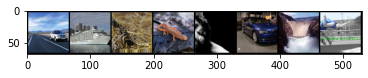

Étiquettes :tensor(609) tensor(628) tensor(44) tensor(27) tensor(570) tensor(511) tensor(525) tensor(602)
torch.Size([8, 3, 64, 64])
torch.Size([8, 12288])


In [5]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Afficher les images
imshow(torchvision.utils.make_grid(images))
# Afficher les étiquettes
print("Étiquettes :" + ' '.join('%9s' % labels[j] for j in range(8)))

flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

### Modèle de classification

Ce modèle est une modification du [Darknet Reference Network](https://pjreddie.com/darknet/imagenet/#reference) pour s'ajuster à la taille plus petite de notre jeu de données (images `64x64` plutôt que `256x256`). Il est constitué de couches de convolution `3x3` + *maxpooling* successives se terminant par un pooling moyen global et un couche entièrement connectée.

> **Note** : Puisqque la normalisation par lot (*batch normalization*) est utilisée, il est possible de désactiver les biais dans les couches de convolution. `nn.BatchNorm2d` a un biais intégré et la soustraction de la moyenne annulerait tous biais considérés dans la couche de convolution.

In [6]:
class Darknet64(nn.Module):
    def __init__(self):
        super(Darknet64, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256, 1000)

    def forward(self, x):
        # Entrée : 64x64x3

        # Chaque bloc est constitué des couches suivantes :
        # x = self.conv1(x)
        # x = self.bn1(x)
        # x = F.relu(x)
        # x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2) # 32x32x16
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2) # 16x16x32
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2) # 8x8x64
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2) # 4x4x128
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2) # 2x2x256

        # Pooling global moyen avec tous les canaux
        # L'entrée pourraît être de taille 2x2x256, 4x4x256, 7x3x256, 
        # La sortie seraît dans ce cas toujour un vecteur de longueur 256
        x = F.adaptive_avg_pool2d(x, 1)                                            # 1x1x256
        x = torch.flatten(x, 1)                                                    # Vecteur 256
        
        x = self.fc1(x)
        return x

### Entraînement

La fonction d'entraînement est similaire aux versions utilisées pour les tutoriels précédents, avec quelques modifications. En particulier, il y a maintenant un paramètre `schedule` pour contrôler la modification du taux d'apprentissage en cours d'entrâinement, et aussi un paramètre `checkpoint_path` qui pointe vers l'endroit où les sauvegardes en cours d'entraînement seront enregistées (si ce paramètre est fourni).

Le principe de l'entraînement est le même : choisir un lot, faire la propagation avant du modèle, calculer la perte, exécuter la rétropropagation, et mettre à jour les paramètres.

In [7]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Charger le dernier état de l'entraînement
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Utiliser le lr pour l'époque où est rendu l'entraînement
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Taux d'apprentissage : %f" % schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Mise à jour du taux d'apprentissage (lorsqu'on utilise `schedule`)
        if epoch in schedule:
            print ("Taux d'apprentissage : %f" % schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Calcul de toutes les dérivées partielles grâce à autograd
            optimizer.step() # Effectue un pas dans la direction du gradient

            losses.append(loss.item())
            sum_loss += loss.item()
            
            if i % print_every == print_every-1:    # Affiche la progression chaque 10 mini-lots
                if verbose:
                    print('[%d, %5d] Perte: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

def accuracy(net, dataloader):
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')

#### Entraînement à partir de zéro

Pour commencer l'entraînement, on peut tout simplement créer le modèle et invoquer la commande d'entraînement.

> **Note** : l'entraînement peut prendre beaucoup de temps (p.ex. une nuit complète !)

Pour cet exercice, l'entraînement sera effectué avec la progression suivante pour le taux d'apprentissage :

- Les 5 premières époques avec `lr=0.1`
- Les 10 époques suivantes avec `lr=0.01`
- Les 5 dernières avec `lr=0.001`

Ce choix est arbitraire. Vous pouvez expérimenter avec d'autres types de variations du taux d'apprentissage.

In [8]:
net = Darknet64()
losses = train(net, data['train'], epochs=20, schedule={0:.1, 5:.01, 15:.001}, checkpoint_path=checkpoints)

Taux d'apprentissage : 0.100000
[0,    10] Perte: 7.067
[0,    20] Perte: 7.068
[0,    30] Perte: 7.041
[0,    40] Perte: 6.994
[0,    50] Perte: 6.958
[0,    60] Perte: 6.907
[0,    70] Perte: 6.916
[0,    80] Perte: 6.900
[0,    90] Perte: 6.855
[0,   100] Perte: 6.850
[0,   110] Perte: 6.846
[0,   120] Perte: 6.815
[0,   130] Perte: 6.800
[0,   140] Perte: 6.810
[0,   150] Perte: 6.765


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[0,   160] Perte: 6.741
[0,   170] Perte: 6.742
[0,   180] Perte: 6.764
[0,   190] Perte: 6.693
[0,   200] Perte: 6.715
[0,   210] Perte: 6.664
[0,   220] Perte: 6.672
[0,   230] Perte: 6.648
[0,   240] Perte: 6.641
[0,   250] Perte: 6.623
[0,   260] Perte: 6.570
[0,   270] Perte: 6.561
[0,   280] Perte: 6.619
[0,   290] Perte: 6.570
[0,   300] Perte: 6.547
[0,   310] Perte: 6.556
[0,   320] Perte: 6.545
[0,   330] Perte: 6.527
[0,   340] Perte: 6.505
[0,   350] Perte: 6.503
[0,   360] Perte: 6.510
[0,   370] Perte: 6.476
[0,   380] Perte: 6.437
[0,   390] Perte: 6.447
[0,   400] Perte: 6.405
[0,   410] Perte: 6.465
[0,   420] Perte: 6.428
[0,   430] Perte: 6.372
[0,   440] Perte: 6.339
[0,   450] Perte: 6.383
[0,   460] Perte: 6.365
[0,   470] Perte: 6.367
[0,   480] Perte: 6.306
[0,   490] Perte: 6.340
[0,   500] Perte: 6.308
[0,   510] Perte: 6.341
[0,   520] Perte: 6.316
[0,   530] Perte: 6.213
[0,   540] Perte: 6.264
[0,   550] Perte: 6.329
[0,   560] Perte: 6.301
[0,   570] Perte

[0,  3580] Perte: 5.041
[0,  3590] Perte: 5.106
[0,  3600] Perte: 5.013
[0,  3610] Perte: 5.093
[0,  3620] Perte: 5.129
[0,  3630] Perte: 5.048
[0,  3640] Perte: 5.132
[0,  3650] Perte: 5.007
[0,  3660] Perte: 5.050
[0,  3670] Perte: 5.038
[0,  3680] Perte: 5.033
[0,  3690] Perte: 4.984
[0,  3700] Perte: 5.036
[0,  3710] Perte: 5.080
[0,  3720] Perte: 5.051
[0,  3730] Perte: 5.034
[0,  3740] Perte: 5.092
[0,  3750] Perte: 4.971
[0,  3760] Perte: 4.914
[0,  3770] Perte: 5.057
[0,  3780] Perte: 5.007
[0,  3790] Perte: 5.036
[0,  3800] Perte: 5.070
[0,  3810] Perte: 5.055
[0,  3820] Perte: 4.998
[0,  3830] Perte: 5.078
[0,  3840] Perte: 5.063
[0,  3850] Perte: 5.032
[0,  3860] Perte: 5.073
[0,  3870] Perte: 5.053
[0,  3880] Perte: 5.085
[0,  3890] Perte: 5.045
[0,  3900] Perte: 5.014
[0,  3910] Perte: 4.957
[0,  3920] Perte: 5.015
[0,  3930] Perte: 5.097
[0,  3940] Perte: 5.029
[0,  3950] Perte: 5.001
[0,  3960] Perte: 5.121
[0,  3970] Perte: 5.088
[0,  3980] Perte: 5.042
[0,  3990] Perte

[0,  7000] Perte: 4.881
[0,  7010] Perte: 4.854
[0,  7020] Perte: 4.836
[0,  7030] Perte: 4.819
[0,  7040] Perte: 4.863
[0,  7050] Perte: 4.833
[0,  7060] Perte: 4.812
[0,  7070] Perte: 4.740
[0,  7080] Perte: 4.774
[0,  7090] Perte: 4.884
[0,  7100] Perte: 4.663
[0,  7110] Perte: 4.803
[0,  7120] Perte: 4.797
[0,  7130] Perte: 4.805
[0,  7140] Perte: 4.821
[0,  7150] Perte: 4.757
[0,  7160] Perte: 4.820
[0,  7170] Perte: 4.793
[0,  7180] Perte: 4.872
[0,  7190] Perte: 4.814
[0,  7200] Perte: 4.834
[0,  7210] Perte: 4.813
[0,  7220] Perte: 4.886
[0,  7230] Perte: 4.728
[0,  7240] Perte: 4.907
[0,  7250] Perte: 4.847
[0,  7260] Perte: 4.819
[0,  7270] Perte: 4.846
[0,  7280] Perte: 4.858
[0,  7290] Perte: 4.803
[0,  7300] Perte: 4.877
[0,  7310] Perte: 4.760
[0,  7320] Perte: 4.779
[0,  7330] Perte: 4.827
[0,  7340] Perte: 4.821
[0,  7350] Perte: 4.757
[0,  7360] Perte: 4.818
[0,  7370] Perte: 4.787
[0,  7380] Perte: 4.735
[0,  7390] Perte: 4.726
[0,  7400] Perte: 4.767
[0,  7410] Perte

[1,   410] Perte: 4.674
[1,   420] Perte: 4.749
[1,   430] Perte: 4.678
[1,   440] Perte: 4.649
[1,   450] Perte: 4.698
[1,   460] Perte: 4.679
[1,   470] Perte: 4.749
[1,   480] Perte: 4.668
[1,   490] Perte: 4.659
[1,   500] Perte: 4.734
[1,   510] Perte: 4.732
[1,   520] Perte: 4.788
[1,   530] Perte: 4.744
[1,   540] Perte: 4.696
[1,   550] Perte: 4.729
[1,   560] Perte: 4.763
[1,   570] Perte: 4.662
[1,   580] Perte: 4.742
[1,   590] Perte: 4.785
[1,   600] Perte: 4.755
[1,   610] Perte: 4.753
[1,   620] Perte: 4.746
[1,   630] Perte: 4.737
[1,   640] Perte: 4.715
[1,   650] Perte: 4.768
[1,   660] Perte: 4.710
[1,   670] Perte: 4.720
[1,   680] Perte: 4.684
[1,   690] Perte: 4.748
[1,   700] Perte: 4.711
[1,   710] Perte: 4.736
[1,   720] Perte: 4.796
[1,   730] Perte: 4.739
[1,   740] Perte: 4.689
[1,   750] Perte: 4.759
[1,   760] Perte: 4.744
[1,   770] Perte: 4.750
[1,   780] Perte: 4.754
[1,   790] Perte: 4.681
[1,   800] Perte: 4.864
[1,   810] Perte: 4.791
[1,   820] Perte

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[1,  3810] Perte: 4.722
[1,  3820] Perte: 4.584
[1,  3830] Perte: 4.776
[1,  3840] Perte: 4.707
[1,  3850] Perte: 4.716
[1,  3860] Perte: 4.678
[1,  3870] Perte: 4.741
[1,  3880] Perte: 4.759
[1,  3890] Perte: 4.622
[1,  3900] Perte: 4.659
[1,  3910] Perte: 4.682
[1,  3920] Perte: 4.636
[1,  3930] Perte: 4.645
[1,  3940] Perte: 4.692
[1,  3950] Perte: 4.664
[1,  3960] Perte: 4.627
[1,  3970] Perte: 4.655
[1,  3980] Perte: 4.637
[1,  3990] Perte: 4.624
[1,  4000] Perte: 4.685
[1,  4010] Perte: 4.671
[1,  4020] Perte: 4.674
[1,  4030] Perte: 4.660
[1,  4040] Perte: 4.500
[1,  4050] Perte: 4.716
[1,  4060] Perte: 4.771
[1,  4070] Perte: 4.681
[1,  4080] Perte: 4.707
[1,  4090] Perte: 4.564
[1,  4100] Perte: 4.619
[1,  4110] Perte: 4.643
[1,  4120] Perte: 4.700
[1,  4130] Perte: 4.674
[1,  4140] Perte: 4.640
[1,  4150] Perte: 4.745
[1,  4160] Perte: 4.672
[1,  4170] Perte: 4.760
[1,  4180] Perte: 4.665
[1,  4190] Perte: 4.607
[1,  4200] Perte: 4.602
[1,  4210] Perte: 4.638
[1,  4220] Perte

[1,  7230] Perte: 4.733
[1,  7240] Perte: 4.575
[1,  7250] Perte: 4.656
[1,  7260] Perte: 4.661
[1,  7270] Perte: 4.509
[1,  7280] Perte: 4.616
[1,  7290] Perte: 4.610
[1,  7300] Perte: 4.630
[1,  7310] Perte: 4.603
[1,  7320] Perte: 4.570
[1,  7330] Perte: 4.544
[1,  7340] Perte: 4.572
[1,  7350] Perte: 4.619
[1,  7360] Perte: 4.654
[1,  7370] Perte: 4.653
[1,  7380] Perte: 4.613
[1,  7390] Perte: 4.591
[1,  7400] Perte: 4.691
[1,  7410] Perte: 4.647
[1,  7420] Perte: 4.680
[1,  7430] Perte: 4.616
[1,  7440] Perte: 4.655
[1,  7450] Perte: 4.625
[1,  7460] Perte: 4.604
[1,  7470] Perte: 4.666
[1,  7480] Perte: 4.703
[1,  7490] Perte: 4.622
[1,  7500] Perte: 4.622
[1,  7510] Perte: 4.713
[1,  7520] Perte: 4.714
[1,  7530] Perte: 4.617
[1,  7540] Perte: 4.533
[1,  7550] Perte: 4.639
[1,  7560] Perte: 4.744
[1,  7570] Perte: 4.612
[1,  7580] Perte: 4.616
[1,  7590] Perte: 4.511
[1,  7600] Perte: 4.544
[1,  7610] Perte: 4.678
[1,  7620] Perte: 4.676
[1,  7630] Perte: 4.680
[1,  7640] Perte

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[1,  8590] Perte: 4.569
[1,  8600] Perte: 4.668
[1,  8610] Perte: 4.702
[1,  8620] Perte: 4.642
[1,  8630] Perte: 4.563
[1,  8640] Perte: 4.628
[1,  8650] Perte: 4.696
[1,  8660] Perte: 4.651
[1,  8670] Perte: 4.609
[1,  8680] Perte: 4.633
[1,  8690] Perte: 4.617
[1,  8700] Perte: 4.732
[1,  8710] Perte: 4.654
[1,  8720] Perte: 4.640
[1,  8730] Perte: 4.517
[1,  8740] Perte: 4.595
[1,  8750] Perte: 4.514
[1,  8760] Perte: 4.647
[1,  8770] Perte: 4.711
[1,  8780] Perte: 4.627
[1,  8790] Perte: 4.528
[1,  8800] Perte: 4.615
[1,  8810] Perte: 4.644
[1,  8820] Perte: 4.698
[1,  8830] Perte: 4.587
[1,  8840] Perte: 4.632
[1,  8850] Perte: 4.649
[1,  8860] Perte: 4.545
[1,  8870] Perte: 4.710
[1,  8880] Perte: 4.609
[1,  8890] Perte: 4.673
[1,  8900] Perte: 4.538
[1,  8910] Perte: 4.607
[1,  8920] Perte: 4.635
[1,  8930] Perte: 4.676
[1,  8940] Perte: 4.636
[1,  8950] Perte: 4.647
[1,  8960] Perte: 4.662
[1,  8970] Perte: 4.653
[1,  8980] Perte: 4.695
[1,  8990] Perte: 4.637
[1,  9000] Perte

[2,  2000] Perte: 4.609
[2,  2010] Perte: 4.532
[2,  2020] Perte: 4.513
[2,  2030] Perte: 4.622
[2,  2040] Perte: 4.597
[2,  2050] Perte: 4.587
[2,  2060] Perte: 4.608
[2,  2070] Perte: 4.540
[2,  2080] Perte: 4.591
[2,  2090] Perte: 4.534
[2,  2100] Perte: 4.608
[2,  2110] Perte: 4.747
[2,  2120] Perte: 4.603
[2,  2130] Perte: 4.518
[2,  2140] Perte: 4.609
[2,  2150] Perte: 4.604
[2,  2160] Perte: 4.621
[2,  2170] Perte: 4.576
[2,  2180] Perte: 4.661
[2,  2190] Perte: 4.656
[2,  2200] Perte: 4.593
[2,  2210] Perte: 4.701
[2,  2220] Perte: 4.607
[2,  2230] Perte: 4.637
[2,  2240] Perte: 4.641
[2,  2250] Perte: 4.658
[2,  2260] Perte: 4.647
[2,  2270] Perte: 4.538
[2,  2280] Perte: 4.540
[2,  2290] Perte: 4.643
[2,  2300] Perte: 4.704
[2,  2310] Perte: 4.488
[2,  2320] Perte: 4.541
[2,  2330] Perte: 4.516
[2,  2340] Perte: 4.695
[2,  2350] Perte: 4.650
[2,  2360] Perte: 4.593
[2,  2370] Perte: 4.552
[2,  2380] Perte: 4.601
[2,  2390] Perte: 4.641
[2,  2400] Perte: 4.645
[2,  2410] Perte

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[2,  4310] Perte: 4.643
[2,  4320] Perte: 4.618
[2,  4330] Perte: 4.537
[2,  4340] Perte: 4.611
[2,  4350] Perte: 4.635
[2,  4360] Perte: 4.557
[2,  4370] Perte: 4.563
[2,  4380] Perte: 4.550
[2,  4390] Perte: 4.593
[2,  4400] Perte: 4.542
[2,  4410] Perte: 4.599
[2,  4420] Perte: 4.600
[2,  4430] Perte: 4.641
[2,  4440] Perte: 4.669
[2,  4450] Perte: 4.695
[2,  4460] Perte: 4.704
[2,  4470] Perte: 4.644
[2,  4480] Perte: 4.643
[2,  4490] Perte: 4.600
[2,  4500] Perte: 4.638
[2,  4510] Perte: 4.501
[2,  4520] Perte: 4.650
[2,  4530] Perte: 4.533
[2,  4540] Perte: 4.695
[2,  4550] Perte: 4.640
[2,  4560] Perte: 4.524
[2,  4570] Perte: 4.565
[2,  4580] Perte: 4.523
[2,  4590] Perte: 4.543
[2,  4600] Perte: 4.629
[2,  4610] Perte: 4.609
[2,  4620] Perte: 4.578
[2,  4630] Perte: 4.630
[2,  4640] Perte: 4.655
[2,  4650] Perte: 4.576
[2,  4660] Perte: 4.657
[2,  4670] Perte: 4.604
[2,  4680] Perte: 4.580
[2,  4690] Perte: 4.702
[2,  4700] Perte: 4.528
[2,  4710] Perte: 4.371
[2,  4720] Perte

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[2,  6840] Perte: 4.669
[2,  6850] Perte: 4.534
[2,  6860] Perte: 4.624
[2,  6870] Perte: 4.570
[2,  6880] Perte: 4.649
[2,  6890] Perte: 4.560
[2,  6900] Perte: 4.643
[2,  6910] Perte: 4.649
[2,  6920] Perte: 4.557
[2,  6930] Perte: 4.613
[2,  6940] Perte: 4.647
[2,  6950] Perte: 4.608
[2,  6960] Perte: 4.609
[2,  6970] Perte: 4.623
[2,  6980] Perte: 4.658
[2,  6990] Perte: 4.675
[2,  7000] Perte: 4.546
[2,  7010] Perte: 4.641
[2,  7020] Perte: 4.542
[2,  7030] Perte: 4.632
[2,  7040] Perte: 4.532
[2,  7050] Perte: 4.660
[2,  7060] Perte: 4.673
[2,  7070] Perte: 4.576
[2,  7080] Perte: 4.575
[2,  7090] Perte: 4.563
[2,  7100] Perte: 4.654
[2,  7110] Perte: 4.558
[2,  7120] Perte: 4.649
[2,  7130] Perte: 4.631
[2,  7140] Perte: 4.529
[2,  7150] Perte: 4.642
[2,  7160] Perte: 4.545
[2,  7170] Perte: 4.563
[2,  7180] Perte: 4.567
[2,  7190] Perte: 4.515
[2,  7200] Perte: 4.672
[2,  7210] Perte: 4.693
[2,  7220] Perte: 4.564
[2,  7230] Perte: 4.540
[2,  7240] Perte: 4.641
[2,  7250] Perte

[3,   250] Perte: 4.555
[3,   260] Perte: 4.504
[3,   270] Perte: 4.507
[3,   280] Perte: 4.605
[3,   290] Perte: 4.589
[3,   300] Perte: 4.481
[3,   310] Perte: 4.573
[3,   320] Perte: 4.598
[3,   330] Perte: 4.564
[3,   340] Perte: 4.495
[3,   350] Perte: 4.517
[3,   360] Perte: 4.593
[3,   370] Perte: 4.655
[3,   380] Perte: 4.642
[3,   390] Perte: 4.473
[3,   400] Perte: 4.595
[3,   410] Perte: 4.539
[3,   420] Perte: 4.565
[3,   430] Perte: 4.633
[3,   440] Perte: 4.660
[3,   450] Perte: 4.583
[3,   460] Perte: 4.623
[3,   470] Perte: 4.623
[3,   480] Perte: 4.615
[3,   490] Perte: 4.497
[3,   500] Perte: 4.553
[3,   510] Perte: 4.541
[3,   520] Perte: 4.546
[3,   530] Perte: 4.588
[3,   540] Perte: 4.551
[3,   550] Perte: 4.601
[3,   560] Perte: 4.620
[3,   570] Perte: 4.534
[3,   580] Perte: 4.545
[3,   590] Perte: 4.648
[3,   600] Perte: 4.538
[3,   610] Perte: 4.534
[3,   620] Perte: 4.562
[3,   630] Perte: 4.642
[3,   640] Perte: 4.684
[3,   650] Perte: 4.566
[3,   660] Perte

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[3,  3300] Perte: 4.582
[3,  3310] Perte: 4.554
[3,  3320] Perte: 4.544
[3,  3330] Perte: 4.556
[3,  3340] Perte: 4.618
[3,  3350] Perte: 4.617
[3,  3360] Perte: 4.572
[3,  3370] Perte: 4.567
[3,  3380] Perte: 4.583
[3,  3390] Perte: 4.580
[3,  3400] Perte: 4.509
[3,  3410] Perte: 4.551
[3,  3420] Perte: 4.592
[3,  3430] Perte: 4.649
[3,  3440] Perte: 4.588
[3,  3450] Perte: 4.551
[3,  3460] Perte: 4.490
[3,  3470] Perte: 4.643
[3,  3480] Perte: 4.652
[3,  3490] Perte: 4.606
[3,  3500] Perte: 4.560
[3,  3510] Perte: 4.635
[3,  3520] Perte: 4.677
[3,  3530] Perte: 4.587
[3,  3540] Perte: 4.613
[3,  3550] Perte: 4.677
[3,  3560] Perte: 4.619
[3,  3570] Perte: 4.627
[3,  3580] Perte: 4.610
[3,  3590] Perte: 4.486
[3,  3600] Perte: 4.496
[3,  3610] Perte: 4.558
[3,  3620] Perte: 4.557
[3,  3630] Perte: 4.595
[3,  3640] Perte: 4.548
[3,  3650] Perte: 4.533
[3,  3660] Perte: 4.565
[3,  3670] Perte: 4.580
[3,  3680] Perte: 4.525
[3,  3690] Perte: 4.594
[3,  3700] Perte: 4.628
[3,  3710] Perte

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[3,  4590] Perte: 4.653
[3,  4600] Perte: 4.526
[3,  4610] Perte: 4.681
[3,  4620] Perte: 4.586
[3,  4630] Perte: 4.504
[3,  4640] Perte: 4.651
[3,  4650] Perte: 4.608
[3,  4660] Perte: 4.589
[3,  4670] Perte: 4.656
[3,  4680] Perte: 4.673
[3,  4690] Perte: 4.556
[3,  4700] Perte: 4.715
[3,  4710] Perte: 4.580
[3,  4720] Perte: 4.693
[3,  4730] Perte: 4.592
[3,  4740] Perte: 4.557
[3,  4750] Perte: 4.461
[3,  4760] Perte: 4.595
[3,  4770] Perte: 4.521
[3,  4780] Perte: 4.485
[3,  4790] Perte: 4.614
[3,  4800] Perte: 4.528
[3,  4810] Perte: 4.568
[3,  4820] Perte: 4.599
[3,  4830] Perte: 4.665
[3,  4840] Perte: 4.669
[3,  4850] Perte: 4.618
[3,  4860] Perte: 4.607
[3,  4870] Perte: 4.568
[3,  4880] Perte: 4.567
[3,  4890] Perte: 4.635
[3,  4900] Perte: 4.595
[3,  4910] Perte: 4.542
[3,  4920] Perte: 4.658
[3,  4930] Perte: 4.594
[3,  4940] Perte: 4.509
[3,  4950] Perte: 4.600
[3,  4960] Perte: 4.610
[3,  4970] Perte: 4.524
[3,  4980] Perte: 4.620
[3,  4990] Perte: 4.579
[3,  5000] Perte

[3,  8010] Perte: 4.632
[3,  8020] Perte: 4.574
[3,  8030] Perte: 4.514
[3,  8040] Perte: 4.583
[3,  8050] Perte: 4.541
[3,  8060] Perte: 4.610
[3,  8070] Perte: 4.565
[3,  8080] Perte: 4.590
[3,  8090] Perte: 4.584
[3,  8100] Perte: 4.581
[3,  8110] Perte: 4.644
[3,  8120] Perte: 4.696
[3,  8130] Perte: 4.589
[3,  8140] Perte: 4.495
[3,  8150] Perte: 4.540
[3,  8160] Perte: 4.577
[3,  8170] Perte: 4.658
[3,  8180] Perte: 4.562
[3,  8190] Perte: 4.700
[3,  8200] Perte: 4.590
[3,  8210] Perte: 4.406
[3,  8220] Perte: 4.591
[3,  8230] Perte: 4.477
[3,  8240] Perte: 4.538
[3,  8250] Perte: 4.580
[3,  8260] Perte: 4.531
[3,  8270] Perte: 4.620
[3,  8280] Perte: 4.632
[3,  8290] Perte: 4.604
[3,  8300] Perte: 4.587
[3,  8310] Perte: 4.552
[3,  8320] Perte: 4.636
[3,  8330] Perte: 4.503
[3,  8340] Perte: 4.494
[3,  8350] Perte: 4.645
[3,  8360] Perte: 4.544
[3,  8370] Perte: 4.511
[3,  8380] Perte: 4.579
[3,  8390] Perte: 4.517
[3,  8400] Perte: 4.397
[3,  8410] Perte: 4.681
[3,  8420] Perte

[4,  1420] Perte: 4.547
[4,  1430] Perte: 4.609
[4,  1440] Perte: 4.395
[4,  1450] Perte: 4.607
[4,  1460] Perte: 4.535
[4,  1470] Perte: 4.529
[4,  1480] Perte: 4.492
[4,  1490] Perte: 4.524
[4,  1500] Perte: 4.547
[4,  1510] Perte: 4.561
[4,  1520] Perte: 4.575
[4,  1530] Perte: 4.617
[4,  1540] Perte: 4.597
[4,  1550] Perte: 4.538
[4,  1560] Perte: 4.624
[4,  1570] Perte: 4.595
[4,  1580] Perte: 4.622
[4,  1590] Perte: 4.675
[4,  1600] Perte: 4.539
[4,  1610] Perte: 4.518
[4,  1620] Perte: 4.573
[4,  1630] Perte: 4.499
[4,  1640] Perte: 4.552
[4,  1650] Perte: 4.567
[4,  1660] Perte: 4.605
[4,  1670] Perte: 4.552
[4,  1680] Perte: 4.518
[4,  1690] Perte: 4.526
[4,  1700] Perte: 4.506
[4,  1710] Perte: 4.628
[4,  1720] Perte: 4.608
[4,  1730] Perte: 4.531
[4,  1740] Perte: 4.626
[4,  1750] Perte: 4.477
[4,  1760] Perte: 4.484
[4,  1770] Perte: 4.513
[4,  1780] Perte: 4.588
[4,  1790] Perte: 4.481
[4,  1800] Perte: 4.580
[4,  1810] Perte: 4.592
[4,  1820] Perte: 4.593
[4,  1830] Perte

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[4,  2570] Perte: 4.712
[4,  2580] Perte: 4.623
[4,  2590] Perte: 4.599
[4,  2600] Perte: 4.561
[4,  2610] Perte: 4.592
[4,  2620] Perte: 4.524
[4,  2630] Perte: 4.595
[4,  2640] Perte: 4.561
[4,  2650] Perte: 4.531
[4,  2660] Perte: 4.570
[4,  2670] Perte: 4.547
[4,  2680] Perte: 4.559
[4,  2690] Perte: 4.621
[4,  2700] Perte: 4.505
[4,  2710] Perte: 4.585
[4,  2720] Perte: 4.419
[4,  2730] Perte: 4.550
[4,  2740] Perte: 4.461
[4,  2750] Perte: 4.540
[4,  2760] Perte: 4.448
[4,  2770] Perte: 4.545
[4,  2780] Perte: 4.590
[4,  2790] Perte: 4.518
[4,  2800] Perte: 4.507
[4,  2810] Perte: 4.547
[4,  2820] Perte: 4.534
[4,  2830] Perte: 4.582
[4,  2840] Perte: 4.638
[4,  2850] Perte: 4.603
[4,  2860] Perte: 4.634
[4,  2870] Perte: 4.546
[4,  2880] Perte: 4.602
[4,  2890] Perte: 4.580
[4,  2900] Perte: 4.488
[4,  2910] Perte: 4.672
[4,  2920] Perte: 4.536
[4,  2930] Perte: 4.501
[4,  2940] Perte: 4.512
[4,  2950] Perte: 4.552
[4,  2960] Perte: 4.623
[4,  2970] Perte: 4.553
[4,  2980] Perte

[4,  5990] Perte: 4.531
[4,  6000] Perte: 4.518
[4,  6010] Perte: 4.641
[4,  6020] Perte: 4.598
[4,  6030] Perte: 4.511
[4,  6040] Perte: 4.641
[4,  6050] Perte: 4.640
[4,  6060] Perte: 4.538
[4,  6070] Perte: 4.670
[4,  6080] Perte: 4.662
[4,  6090] Perte: 4.516
[4,  6100] Perte: 4.533
[4,  6110] Perte: 4.653
[4,  6120] Perte: 4.579
[4,  6130] Perte: 4.547
[4,  6140] Perte: 4.559
[4,  6150] Perte: 4.477
[4,  6160] Perte: 4.560
[4,  6170] Perte: 4.514
[4,  6180] Perte: 4.518
[4,  6190] Perte: 4.618
[4,  6200] Perte: 4.603
[4,  6210] Perte: 4.490
[4,  6220] Perte: 4.647
[4,  6230] Perte: 4.613
[4,  6240] Perte: 4.610
[4,  6250] Perte: 4.492
[4,  6260] Perte: 4.490
[4,  6270] Perte: 4.548
[4,  6280] Perte: 4.609
[4,  6290] Perte: 4.633
[4,  6300] Perte: 4.605
[4,  6310] Perte: 4.613
[4,  6320] Perte: 4.534
[4,  6330] Perte: 4.512
[4,  6340] Perte: 4.519
[4,  6350] Perte: 4.667
[4,  6360] Perte: 4.523
[4,  6370] Perte: 4.660
[4,  6380] Perte: 4.583
[4,  6390] Perte: 4.570
[4,  6400] Perte

[4,  9410] Perte: 4.591
[4,  9420] Perte: 4.538
[4,  9430] Perte: 4.621
[4,  9440] Perte: 4.641
[4,  9450] Perte: 4.632
[4,  9460] Perte: 4.569
[4,  9470] Perte: 4.589
[4,  9480] Perte: 4.444
[4,  9490] Perte: 4.563
[4,  9500] Perte: 4.612
[4,  9510] Perte: 4.558
[4,  9520] Perte: 4.485
[4,  9530] Perte: 4.570
[4,  9540] Perte: 4.588
[4,  9550] Perte: 4.565
[4,  9560] Perte: 4.538
[4,  9570] Perte: 4.371
[4,  9580] Perte: 4.496
[4,  9590] Perte: 4.571
[4,  9600] Perte: 4.560
[4,  9610] Perte: 4.579
[4,  9620] Perte: 4.576
[4,  9630] Perte: 4.573
[4,  9640] Perte: 4.555
[4,  9650] Perte: 4.532
[4,  9660] Perte: 4.417
[4,  9670] Perte: 4.580
[4,  9680] Perte: 4.519
[4,  9690] Perte: 4.542
[4,  9700] Perte: 4.511
[4,  9710] Perte: 4.590
[4,  9720] Perte: 4.472
[4,  9730] Perte: 4.530
[4,  9740] Perte: 4.567
[4,  9750] Perte: 4.541
[4,  9760] Perte: 4.478
[4,  9770] Perte: 4.620
[4,  9780] Perte: 4.612
[4,  9790] Perte: 4.527
[4,  9800] Perte: 4.496
[4,  9810] Perte: 4.509
[4,  9820] Perte

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[5,  2000] Perte: 3.803
[5,  2010] Perte: 3.799
[5,  2020] Perte: 3.957
[5,  2030] Perte: 3.906
[5,  2040] Perte: 3.929
[5,  2050] Perte: 3.775
[5,  2060] Perte: 3.905
[5,  2070] Perte: 3.977
[5,  2080] Perte: 3.888
[5,  2090] Perte: 3.848
[5,  2100] Perte: 3.789
[5,  2110] Perte: 3.833
[5,  2120] Perte: 3.949
[5,  2130] Perte: 3.777
[5,  2140] Perte: 3.876
[5,  2150] Perte: 3.924
[5,  2160] Perte: 3.848
[5,  2170] Perte: 3.877
[5,  2180] Perte: 3.987
[5,  2190] Perte: 3.826
[5,  2200] Perte: 4.020
[5,  2210] Perte: 3.834
[5,  2220] Perte: 3.835
[5,  2230] Perte: 3.818
[5,  2240] Perte: 3.833
[5,  2250] Perte: 3.855
[5,  2260] Perte: 3.828
[5,  2270] Perte: 3.743
[5,  2280] Perte: 3.949
[5,  2290] Perte: 3.793
[5,  2300] Perte: 3.877
[5,  2310] Perte: 3.834
[5,  2320] Perte: 3.825
[5,  2330] Perte: 3.825
[5,  2340] Perte: 3.854
[5,  2350] Perte: 3.785
[5,  2360] Perte: 3.889
[5,  2370] Perte: 3.846
[5,  2380] Perte: 3.912
[5,  2390] Perte: 3.908
[5,  2400] Perte: 3.853
[5,  2410] Perte

[5,  5420] Perte: 3.835
[5,  5430] Perte: 3.787
[5,  5440] Perte: 3.831
[5,  5450] Perte: 3.801
[5,  5460] Perte: 3.795
[5,  5470] Perte: 3.858
[5,  5480] Perte: 3.779
[5,  5490] Perte: 3.725
[5,  5500] Perte: 3.796
[5,  5510] Perte: 3.749
[5,  5520] Perte: 3.758
[5,  5530] Perte: 3.676
[5,  5540] Perte: 3.775
[5,  5550] Perte: 3.732
[5,  5560] Perte: 3.771
[5,  5570] Perte: 3.761
[5,  5580] Perte: 3.716
[5,  5590] Perte: 3.814
[5,  5600] Perte: 3.875
[5,  5610] Perte: 3.676
[5,  5620] Perte: 3.745
[5,  5630] Perte: 3.829
[5,  5640] Perte: 3.836
[5,  5650] Perte: 3.814
[5,  5660] Perte: 3.679
[5,  5670] Perte: 3.855
[5,  5680] Perte: 3.629
[5,  5690] Perte: 3.770
[5,  5700] Perte: 3.748
[5,  5710] Perte: 3.794
[5,  5720] Perte: 3.802
[5,  5730] Perte: 3.763
[5,  5740] Perte: 3.755
[5,  5750] Perte: 3.760
[5,  5760] Perte: 3.773
[5,  5770] Perte: 3.712
[5,  5780] Perte: 3.817
[5,  5790] Perte: 3.628
[5,  5800] Perte: 3.850
[5,  5810] Perte: 3.782
[5,  5820] Perte: 3.674
[5,  5830] Perte

[5,  8840] Perte: 3.818
[5,  8850] Perte: 3.915
[5,  8860] Perte: 3.801
[5,  8870] Perte: 3.645
[5,  8880] Perte: 3.727
[5,  8890] Perte: 3.754
[5,  8900] Perte: 3.685
[5,  8910] Perte: 3.747
[5,  8920] Perte: 3.769
[5,  8930] Perte: 3.794
[5,  8940] Perte: 3.817
[5,  8950] Perte: 3.829
[5,  8960] Perte: 3.744
[5,  8970] Perte: 3.815
[5,  8980] Perte: 3.737
[5,  8990] Perte: 3.736
[5,  9000] Perte: 3.753
[5,  9010] Perte: 3.816
[5,  9020] Perte: 3.733
[5,  9030] Perte: 3.771
[5,  9040] Perte: 3.836
[5,  9050] Perte: 3.787
[5,  9060] Perte: 3.757
[5,  9070] Perte: 3.799
[5,  9080] Perte: 3.777
[5,  9090] Perte: 3.875
[5,  9100] Perte: 3.895
[5,  9110] Perte: 3.849
[5,  9120] Perte: 3.847
[5,  9130] Perte: 3.765
[5,  9140] Perte: 3.707
[5,  9150] Perte: 3.806
[5,  9160] Perte: 3.690
[5,  9170] Perte: 3.724
[5,  9180] Perte: 3.833
[5,  9190] Perte: 3.651
[5,  9200] Perte: 3.693
[5,  9210] Perte: 3.828
[5,  9220] Perte: 3.839
[5,  9230] Perte: 3.829
[5,  9240] Perte: 3.762
[5,  9250] Perte

[6,  2250] Perte: 3.710
[6,  2260] Perte: 3.830
[6,  2270] Perte: 3.723
[6,  2280] Perte: 3.694
[6,  2290] Perte: 3.850
[6,  2300] Perte: 3.776
[6,  2310] Perte: 3.785
[6,  2320] Perte: 3.791
[6,  2330] Perte: 3.789
[6,  2340] Perte: 3.721
[6,  2350] Perte: 3.687
[6,  2360] Perte: 3.747
[6,  2370] Perte: 3.784
[6,  2380] Perte: 3.713
[6,  2390] Perte: 3.731
[6,  2400] Perte: 3.737
[6,  2410] Perte: 3.821
[6,  2420] Perte: 3.759
[6,  2430] Perte: 3.794
[6,  2440] Perte: 3.763
[6,  2450] Perte: 3.691
[6,  2460] Perte: 3.652
[6,  2470] Perte: 3.889
[6,  2480] Perte: 3.650
[6,  2490] Perte: 3.735
[6,  2500] Perte: 3.740
[6,  2510] Perte: 3.671
[6,  2520] Perte: 3.729
[6,  2530] Perte: 3.824
[6,  2540] Perte: 3.801
[6,  2550] Perte: 3.701
[6,  2560] Perte: 3.721
[6,  2570] Perte: 3.853
[6,  2580] Perte: 3.766
[6,  2590] Perte: 3.686
[6,  2600] Perte: 3.825
[6,  2610] Perte: 3.681
[6,  2620] Perte: 3.768
[6,  2630] Perte: 3.693
[6,  2640] Perte: 3.671
[6,  2650] Perte: 3.681
[6,  2660] Perte

[6,  5670] Perte: 3.742
[6,  5680] Perte: 3.807
[6,  5690] Perte: 3.673
[6,  5700] Perte: 3.722
[6,  5710] Perte: 3.693
[6,  5720] Perte: 3.821
[6,  5730] Perte: 3.710
[6,  5740] Perte: 3.792
[6,  5750] Perte: 3.784
[6,  5760] Perte: 3.815
[6,  5770] Perte: 3.792
[6,  5780] Perte: 3.813
[6,  5790] Perte: 3.757
[6,  5800] Perte: 3.687
[6,  5810] Perte: 3.778
[6,  5820] Perte: 3.730
[6,  5830] Perte: 3.731
[6,  5840] Perte: 3.698
[6,  5850] Perte: 3.734
[6,  5860] Perte: 3.702
[6,  5870] Perte: 3.745
[6,  5880] Perte: 3.792
[6,  5890] Perte: 3.796
[6,  5900] Perte: 3.824
[6,  5910] Perte: 3.711
[6,  5920] Perte: 3.696
[6,  5930] Perte: 3.769
[6,  5940] Perte: 3.759
[6,  5950] Perte: 3.763
[6,  5960] Perte: 3.720
[6,  5970] Perte: 3.752
[6,  5980] Perte: 3.724
[6,  5990] Perte: 3.772
[6,  6000] Perte: 3.742
[6,  6010] Perte: 3.708
[6,  6020] Perte: 3.786
[6,  6030] Perte: 3.716
[6,  6040] Perte: 3.669
[6,  6050] Perte: 3.791
[6,  6060] Perte: 3.662
[6,  6070] Perte: 3.741
[6,  6080] Perte

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[6,  6220] Perte: 3.702
[6,  6230] Perte: 3.713
[6,  6240] Perte: 3.605
[6,  6250] Perte: 3.710
[6,  6260] Perte: 3.785
[6,  6270] Perte: 3.724
[6,  6280] Perte: 3.719
[6,  6290] Perte: 3.678
[6,  6300] Perte: 3.832
[6,  6310] Perte: 3.812
[6,  6320] Perte: 3.801
[6,  6330] Perte: 3.634
[6,  6340] Perte: 3.836
[6,  6350] Perte: 3.765
[6,  6360] Perte: 3.792
[6,  6370] Perte: 3.679
[6,  6380] Perte: 3.783
[6,  6390] Perte: 3.664
[6,  6400] Perte: 3.827
[6,  6410] Perte: 3.881
[6,  6420] Perte: 3.898
[6,  6430] Perte: 3.746


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[6,  6440] Perte: 3.743
[6,  6450] Perte: 3.762
[6,  6460] Perte: 3.889
[6,  6470] Perte: 3.846
[6,  6480] Perte: 3.819
[6,  6490] Perte: 3.724
[6,  6500] Perte: 3.734
[6,  6510] Perte: 3.821
[6,  6520] Perte: 3.807
[6,  6530] Perte: 3.757
[6,  6540] Perte: 3.734
[6,  6550] Perte: 3.675
[6,  6560] Perte: 3.780
[6,  6570] Perte: 3.777
[6,  6580] Perte: 3.711
[6,  6590] Perte: 3.823
[6,  6600] Perte: 3.687
[6,  6610] Perte: 3.701
[6,  6620] Perte: 3.664
[6,  6630] Perte: 3.703
[6,  6640] Perte: 3.696
[6,  6650] Perte: 3.707
[6,  6660] Perte: 3.802
[6,  6670] Perte: 3.746
[6,  6680] Perte: 3.805
[6,  6690] Perte: 3.758
[6,  6700] Perte: 3.753
[6,  6710] Perte: 3.706
[6,  6720] Perte: 3.748
[6,  6730] Perte: 3.789
[6,  6740] Perte: 3.744
[6,  6750] Perte: 3.702
[6,  6760] Perte: 3.777
[6,  6770] Perte: 3.740
[6,  6780] Perte: 3.824
[6,  6790] Perte: 3.794
[6,  6800] Perte: 3.666
[6,  6810] Perte: 3.664
[6,  6820] Perte: 3.674
[6,  6830] Perte: 3.732
[6,  6840] Perte: 3.691
[6,  6850] Perte

[6,  9860] Perte: 3.770
[6,  9870] Perte: 3.834
[6,  9880] Perte: 3.702
[6,  9890] Perte: 3.696
[6,  9900] Perte: 3.841
[6,  9910] Perte: 3.709
[6,  9920] Perte: 3.764
[6,  9930] Perte: 3.757
[6,  9940] Perte: 3.639
[6,  9950] Perte: 3.636
[6,  9960] Perte: 3.734
[6,  9970] Perte: 3.792
[6,  9980] Perte: 3.655
[6,  9990] Perte: 3.771
[6, 10000] Perte: 3.678
[6, 10010] Perte: 3.785
[7,    10] Perte: 3.722
[7,    20] Perte: 3.900
[7,    30] Perte: 3.801
[7,    40] Perte: 3.816
[7,    50] Perte: 3.732
[7,    60] Perte: 3.685
[7,    70] Perte: 3.720
[7,    80] Perte: 3.765
[7,    90] Perte: 3.800
[7,   100] Perte: 3.837
[7,   110] Perte: 3.720
[7,   120] Perte: 3.732
[7,   130] Perte: 3.717
[7,   140] Perte: 3.733
[7,   150] Perte: 3.680
[7,   160] Perte: 3.695
[7,   170] Perte: 3.709
[7,   180] Perte: 3.788
[7,   190] Perte: 3.720
[7,   200] Perte: 3.753
[7,   210] Perte: 3.770
[7,   220] Perte: 3.720
[7,   230] Perte: 3.725
[7,   240] Perte: 3.708
[7,   250] Perte: 3.654
[7,   260] Perte

[7,  3270] Perte: 3.772
[7,  3280] Perte: 3.806
[7,  3290] Perte: 3.732
[7,  3300] Perte: 3.791
[7,  3310] Perte: 3.732
[7,  3320] Perte: 3.693
[7,  3330] Perte: 3.693
[7,  3340] Perte: 3.823
[7,  3350] Perte: 3.635
[7,  3360] Perte: 3.676
[7,  3370] Perte: 3.831
[7,  3380] Perte: 3.655
[7,  3390] Perte: 3.742
[7,  3400] Perte: 3.923
[7,  3410] Perte: 3.783
[7,  3420] Perte: 3.697
[7,  3430] Perte: 3.631
[7,  3440] Perte: 3.640
[7,  3450] Perte: 3.763
[7,  3460] Perte: 3.755
[7,  3470] Perte: 3.765
[7,  3480] Perte: 3.824
[7,  3490] Perte: 3.685
[7,  3500] Perte: 3.856
[7,  3510] Perte: 3.674
[7,  3520] Perte: 3.743
[7,  3530] Perte: 3.814
[7,  3540] Perte: 3.819
[7,  3550] Perte: 3.708
[7,  3560] Perte: 3.663
[7,  3570] Perte: 3.722
[7,  3580] Perte: 3.750
[7,  3590] Perte: 3.798
[7,  3600] Perte: 3.673
[7,  3610] Perte: 3.713
[7,  3620] Perte: 3.742
[7,  3630] Perte: 3.695
[7,  3640] Perte: 3.791
[7,  3650] Perte: 3.697
[7,  3660] Perte: 3.757
[7,  3670] Perte: 3.765
[7,  3680] Perte

[7,  6690] Perte: 3.764
[7,  6700] Perte: 3.794
[7,  6710] Perte: 3.607
[7,  6720] Perte: 3.747
[7,  6730] Perte: 3.668
[7,  6740] Perte: 3.750
[7,  6750] Perte: 3.869
[7,  6760] Perte: 3.819
[7,  6770] Perte: 3.784
[7,  6780] Perte: 3.774
[7,  6790] Perte: 3.759
[7,  6800] Perte: 3.778
[7,  6810] Perte: 3.848
[7,  6820] Perte: 3.772
[7,  6830] Perte: 3.829
[7,  6840] Perte: 3.746
[7,  6850] Perte: 3.780
[7,  6860] Perte: 3.695
[7,  6870] Perte: 3.816
[7,  6880] Perte: 3.721
[7,  6890] Perte: 3.825
[7,  6900] Perte: 3.733
[7,  6910] Perte: 3.778
[7,  6920] Perte: 3.514
[7,  6930] Perte: 3.681
[7,  6940] Perte: 3.799
[7,  6950] Perte: 3.741
[7,  6960] Perte: 3.687
[7,  6970] Perte: 3.700
[7,  6980] Perte: 3.801
[7,  6990] Perte: 3.666
[7,  7000] Perte: 3.791
[7,  7010] Perte: 3.776
[7,  7020] Perte: 3.715
[7,  7030] Perte: 3.700
[7,  7040] Perte: 3.864
[7,  7050] Perte: 3.824
[7,  7060] Perte: 3.596
[7,  7070] Perte: 3.674
[7,  7080] Perte: 3.748
[7,  7090] Perte: 3.693
[7,  7100] Perte

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[7,  8540] Perte: 3.754
[7,  8550] Perte: 3.817
[7,  8560] Perte: 3.738
[7,  8570] Perte: 3.794
[7,  8580] Perte: 3.680
[7,  8590] Perte: 3.708
[7,  8600] Perte: 3.779
[7,  8610] Perte: 3.684
[7,  8620] Perte: 3.792
[7,  8630] Perte: 3.625
[7,  8640] Perte: 3.585
[7,  8650] Perte: 3.789
[7,  8660] Perte: 3.729
[7,  8670] Perte: 3.750
[7,  8680] Perte: 3.812
[7,  8690] Perte: 3.743
[7,  8700] Perte: 3.833
[7,  8710] Perte: 3.810
[7,  8720] Perte: 3.697
[7,  8730] Perte: 3.851
[7,  8740] Perte: 3.720
[7,  8750] Perte: 3.661
[7,  8760] Perte: 3.775
[7,  8770] Perte: 3.744
[7,  8780] Perte: 3.657
[7,  8790] Perte: 3.700
[7,  8800] Perte: 3.761
[7,  8810] Perte: 3.736
[7,  8820] Perte: 3.724
[7,  8830] Perte: 3.797
[7,  8840] Perte: 3.739
[7,  8850] Perte: 3.756
[7,  8860] Perte: 3.725
[7,  8870] Perte: 3.882
[7,  8880] Perte: 3.749
[7,  8890] Perte: 3.770
[7,  8900] Perte: 3.776
[7,  8910] Perte: 3.670
[7,  8920] Perte: 3.740
[7,  8930] Perte: 3.830
[7,  8940] Perte: 3.681
[7,  8950] Perte

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[8,   510] Perte: 3.751
[8,   520] Perte: 3.812
[8,   530] Perte: 3.668
[8,   540] Perte: 3.819
[8,   550] Perte: 3.701
[8,   560] Perte: 3.834
[8,   570] Perte: 3.615
[8,   580] Perte: 3.680
[8,   590] Perte: 3.816
[8,   600] Perte: 3.838
[8,   610] Perte: 3.643
[8,   620] Perte: 3.636
[8,   630] Perte: 3.669
[8,   640] Perte: 3.674
[8,   650] Perte: 3.711
[8,   660] Perte: 3.678
[8,   670] Perte: 3.780
[8,   680] Perte: 3.723
[8,   690] Perte: 3.660
[8,   700] Perte: 3.731
[8,   710] Perte: 3.612
[8,   720] Perte: 3.597
[8,   730] Perte: 3.718
[8,   740] Perte: 3.609
[8,   750] Perte: 3.727
[8,   760] Perte: 3.618
[8,   770] Perte: 3.710
[8,   780] Perte: 3.773
[8,   790] Perte: 3.635
[8,   800] Perte: 3.646
[8,   810] Perte: 3.689
[8,   820] Perte: 3.659
[8,   830] Perte: 3.688
[8,   840] Perte: 3.591
[8,   850] Perte: 3.732
[8,   860] Perte: 3.792
[8,   870] Perte: 3.735
[8,   880] Perte: 3.687
[8,   890] Perte: 3.708
[8,   900] Perte: 3.674
[8,   910] Perte: 3.710
[8,   920] Perte

[8,  3930] Perte: 3.725
[8,  3940] Perte: 3.823
[8,  3950] Perte: 3.744
[8,  3960] Perte: 3.807
[8,  3970] Perte: 3.746
[8,  3980] Perte: 3.803
[8,  3990] Perte: 3.749
[8,  4000] Perte: 3.751
[8,  4010] Perte: 3.635
[8,  4020] Perte: 3.715
[8,  4030] Perte: 3.709
[8,  4040] Perte: 3.678
[8,  4050] Perte: 3.718
[8,  4060] Perte: 3.691
[8,  4070] Perte: 3.731
[8,  4080] Perte: 3.682
[8,  4090] Perte: 3.697
[8,  4100] Perte: 3.789
[8,  4110] Perte: 3.741
[8,  4120] Perte: 3.800
[8,  4130] Perte: 3.691
[8,  4140] Perte: 3.731
[8,  4150] Perte: 3.790
[8,  4160] Perte: 3.720
[8,  4170] Perte: 3.630
[8,  4180] Perte: 3.768
[8,  4190] Perte: 3.750
[8,  4200] Perte: 3.795
[8,  4210] Perte: 3.685
[8,  4220] Perte: 3.820
[8,  4230] Perte: 3.757
[8,  4240] Perte: 3.701
[8,  4250] Perte: 3.634
[8,  4260] Perte: 3.792
[8,  4270] Perte: 3.824
[8,  4280] Perte: 3.645
[8,  4290] Perte: 3.900
[8,  4300] Perte: 3.700
[8,  4310] Perte: 3.741
[8,  4320] Perte: 3.760
[8,  4330] Perte: 3.635
[8,  4340] Perte

[8,  7350] Perte: 3.838
[8,  7360] Perte: 3.765
[8,  7370] Perte: 3.695
[8,  7380] Perte: 3.702
[8,  7390] Perte: 3.751
[8,  7400] Perte: 3.685
[8,  7410] Perte: 3.767
[8,  7420] Perte: 3.731
[8,  7430] Perte: 3.698
[8,  7440] Perte: 3.592
[8,  7450] Perte: 3.702
[8,  7460] Perte: 3.702
[8,  7470] Perte: 3.670
[8,  7480] Perte: 3.674
[8,  7490] Perte: 3.789
[8,  7500] Perte: 3.814
[8,  7510] Perte: 3.704
[8,  7520] Perte: 3.777
[8,  7530] Perte: 3.686
[8,  7540] Perte: 3.753
[8,  7550] Perte: 3.821
[8,  7560] Perte: 3.628
[8,  7570] Perte: 3.736
[8,  7580] Perte: 3.762
[8,  7590] Perte: 3.671
[8,  7600] Perte: 3.714
[8,  7610] Perte: 3.787
[8,  7620] Perte: 3.700
[8,  7630] Perte: 3.793
[8,  7640] Perte: 3.633
[8,  7650] Perte: 3.671
[8,  7660] Perte: 3.782
[8,  7670] Perte: 3.714
[8,  7680] Perte: 3.838
[8,  7690] Perte: 3.725
[8,  7700] Perte: 3.755
[8,  7710] Perte: 3.730
[8,  7720] Perte: 3.762
[8,  7730] Perte: 3.815
[8,  7740] Perte: 3.663
[8,  7750] Perte: 3.656
[8,  7760] Perte

[9,   760] Perte: 3.722
[9,   770] Perte: 3.704
[9,   780] Perte: 3.656
[9,   790] Perte: 3.706
[9,   800] Perte: 3.672
[9,   810] Perte: 3.711
[9,   820] Perte: 3.738
[9,   830] Perte: 3.607
[9,   840] Perte: 3.744
[9,   850] Perte: 3.721
[9,   860] Perte: 3.658
[9,   870] Perte: 3.684
[9,   880] Perte: 3.725
[9,   890] Perte: 3.683
[9,   900] Perte: 3.685
[9,   910] Perte: 3.593
[9,   920] Perte: 3.659
[9,   930] Perte: 3.702
[9,   940] Perte: 3.715
[9,   950] Perte: 3.731
[9,   960] Perte: 3.795
[9,   970] Perte: 3.761
[9,   980] Perte: 3.713
[9,   990] Perte: 3.897
[9,  1000] Perte: 3.644
[9,  1010] Perte: 3.662
[9,  1020] Perte: 3.719
[9,  1030] Perte: 3.625
[9,  1040] Perte: 3.716
[9,  1050] Perte: 3.822
[9,  1060] Perte: 3.585
[9,  1070] Perte: 3.667
[9,  1080] Perte: 3.742
[9,  1090] Perte: 3.534
[9,  1100] Perte: 3.770
[9,  1110] Perte: 3.711
[9,  1120] Perte: 3.570
[9,  1130] Perte: 3.689
[9,  1140] Perte: 3.626
[9,  1150] Perte: 3.718
[9,  1160] Perte: 3.628
[9,  1170] Perte

[9,  4180] Perte: 3.689
[9,  4190] Perte: 3.691
[9,  4200] Perte: 3.607
[9,  4210] Perte: 3.782
[9,  4220] Perte: 3.559
[9,  4230] Perte: 3.765
[9,  4240] Perte: 3.716
[9,  4250] Perte: 3.595
[9,  4260] Perte: 3.653
[9,  4270] Perte: 3.715
[9,  4280] Perte: 3.690
[9,  4290] Perte: 3.807
[9,  4300] Perte: 3.749
[9,  4310] Perte: 3.721
[9,  4320] Perte: 3.692
[9,  4330] Perte: 3.690
[9,  4340] Perte: 3.706
[9,  4350] Perte: 3.671
[9,  4360] Perte: 3.760
[9,  4370] Perte: 3.645
[9,  4380] Perte: 3.662
[9,  4390] Perte: 3.602
[9,  4400] Perte: 3.807
[9,  4410] Perte: 3.761
[9,  4420] Perte: 3.796
[9,  4430] Perte: 3.746
[9,  4440] Perte: 3.794
[9,  4450] Perte: 3.692
[9,  4460] Perte: 3.703
[9,  4470] Perte: 3.688
[9,  4480] Perte: 3.657
[9,  4490] Perte: 3.689
[9,  4500] Perte: 3.738
[9,  4510] Perte: 3.774
[9,  4520] Perte: 3.563
[9,  4530] Perte: 3.715
[9,  4540] Perte: 3.673
[9,  4550] Perte: 3.746
[9,  4560] Perte: 3.724
[9,  4570] Perte: 3.694
[9,  4580] Perte: 3.704
[9,  4590] Perte

[9,  7600] Perte: 3.748
[9,  7610] Perte: 3.673
[9,  7620] Perte: 3.681
[9,  7630] Perte: 3.710
[9,  7640] Perte: 3.827
[9,  7650] Perte: 3.774
[9,  7660] Perte: 3.724
[9,  7670] Perte: 3.726
[9,  7680] Perte: 3.705
[9,  7690] Perte: 3.790
[9,  7700] Perte: 3.768
[9,  7710] Perte: 3.766
[9,  7720] Perte: 3.741
[9,  7730] Perte: 3.808
[9,  7740] Perte: 3.763
[9,  7750] Perte: 3.801
[9,  7760] Perte: 3.719
[9,  7770] Perte: 3.674
[9,  7780] Perte: 3.608
[9,  7790] Perte: 3.797
[9,  7800] Perte: 3.766
[9,  7810] Perte: 3.602
[9,  7820] Perte: 3.635
[9,  7830] Perte: 3.758
[9,  7840] Perte: 3.717
[9,  7850] Perte: 3.610
[9,  7860] Perte: 3.612
[9,  7870] Perte: 3.776
[9,  7880] Perte: 3.830
[9,  7890] Perte: 3.675
[9,  7900] Perte: 3.704


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[9,  7910] Perte: 3.656
[9,  7920] Perte: 3.751
[9,  7930] Perte: 3.749
[9,  7940] Perte: 3.670
[9,  7950] Perte: 3.788
[9,  7960] Perte: 3.709
[9,  7970] Perte: 3.691
[9,  7980] Perte: 3.639
[9,  7990] Perte: 3.697
[9,  8000] Perte: 3.765
[9,  8010] Perte: 3.656
[9,  8020] Perte: 3.701
[9,  8030] Perte: 3.654
[9,  8040] Perte: 3.707
[9,  8050] Perte: 3.703
[9,  8060] Perte: 3.685
[9,  8070] Perte: 3.576
[9,  8080] Perte: 3.676
[9,  8090] Perte: 3.685
[9,  8100] Perte: 3.618
[9,  8110] Perte: 3.672
[9,  8120] Perte: 3.761
[9,  8130] Perte: 3.607
[9,  8140] Perte: 3.668
[9,  8150] Perte: 3.756
[9,  8160] Perte: 3.807
[9,  8170] Perte: 3.741
[9,  8180] Perte: 3.767
[9,  8190] Perte: 3.721
[9,  8200] Perte: 3.742
[9,  8210] Perte: 3.711
[9,  8220] Perte: 3.633
[9,  8230] Perte: 3.770
[9,  8240] Perte: 3.783
[9,  8250] Perte: 3.689
[9,  8260] Perte: 3.643
[9,  8270] Perte: 3.654
[9,  8280] Perte: 3.691
[9,  8290] Perte: 3.674
[9,  8300] Perte: 3.690
[9,  8310] Perte: 3.760
[9,  8320] Perte

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[9,  9580] Perte: 3.785
[9,  9590] Perte: 3.697
[9,  9600] Perte: 3.686
[9,  9610] Perte: 3.803
[9,  9620] Perte: 3.659
[9,  9630] Perte: 3.747
[9,  9640] Perte: 3.706
[9,  9650] Perte: 3.679
[9,  9660] Perte: 3.792
[9,  9670] Perte: 3.744
[9,  9680] Perte: 3.690
[9,  9690] Perte: 3.672
[9,  9700] Perte: 3.731
[9,  9710] Perte: 3.710
[9,  9720] Perte: 3.720
[9,  9730] Perte: 3.794
[9,  9740] Perte: 3.641
[9,  9750] Perte: 3.608
[9,  9760] Perte: 3.694
[9,  9770] Perte: 3.709
[9,  9780] Perte: 3.662
[9,  9790] Perte: 3.810
[9,  9800] Perte: 3.659
[9,  9810] Perte: 3.753
[9,  9820] Perte: 3.728
[9,  9830] Perte: 3.680
[9,  9840] Perte: 3.681
[9,  9850] Perte: 3.692
[9,  9860] Perte: 3.674
[9,  9870] Perte: 3.736
[9,  9880] Perte: 3.766
[9,  9890] Perte: 3.629
[9,  9900] Perte: 3.655
[9,  9910] Perte: 3.703
[9,  9920] Perte: 3.685
[9,  9930] Perte: 3.654
[9,  9940] Perte: 3.635
[9,  9950] Perte: 3.753
[9,  9960] Perte: 3.676
[9,  9970] Perte: 3.734
[9,  9980] Perte: 3.610
[9,  9990] Perte

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[10,   160] Perte: 3.709
[10,   170] Perte: 3.641
[10,   180] Perte: 3.701
[10,   190] Perte: 3.659
[10,   200] Perte: 3.668
[10,   210] Perte: 3.642
[10,   220] Perte: 3.700
[10,   230] Perte: 3.731
[10,   240] Perte: 3.701
[10,   250] Perte: 3.744
[10,   260] Perte: 3.661
[10,   270] Perte: 3.635
[10,   280] Perte: 3.739
[10,   290] Perte: 3.673
[10,   300] Perte: 3.672
[10,   310] Perte: 3.612
[10,   320] Perte: 3.661
[10,   330] Perte: 3.752
[10,   340] Perte: 3.724
[10,   350] Perte: 3.759
[10,   360] Perte: 3.757
[10,   370] Perte: 3.678
[10,   380] Perte: 3.710
[10,   390] Perte: 3.595
[10,   400] Perte: 3.664
[10,   410] Perte: 3.681
[10,   420] Perte: 3.677
[10,   430] Perte: 3.666
[10,   440] Perte: 3.735
[10,   450] Perte: 3.581
[10,   460] Perte: 3.634
[10,   470] Perte: 3.683
[10,   480] Perte: 3.673
[10,   490] Perte: 3.616
[10,   500] Perte: 3.637
[10,   510] Perte: 3.743
[10,   520] Perte: 3.715
[10,   530] Perte: 3.691
[10,   540] Perte: 3.552
[10,   550] Perte: 3.644


[10,  3440] Perte: 3.730
[10,  3450] Perte: 3.774
[10,  3460] Perte: 3.668
[10,  3470] Perte: 3.763
[10,  3480] Perte: 3.561
[10,  3490] Perte: 3.703
[10,  3500] Perte: 3.726
[10,  3510] Perte: 3.680
[10,  3520] Perte: 3.724
[10,  3530] Perte: 3.756
[10,  3540] Perte: 3.629
[10,  3550] Perte: 3.665
[10,  3560] Perte: 3.720
[10,  3570] Perte: 3.748
[10,  3580] Perte: 3.728
[10,  3590] Perte: 3.603
[10,  3600] Perte: 3.817
[10,  3610] Perte: 3.627
[10,  3620] Perte: 3.680
[10,  3630] Perte: 3.699
[10,  3640] Perte: 3.819
[10,  3650] Perte: 3.753
[10,  3660] Perte: 3.682
[10,  3670] Perte: 3.650
[10,  3680] Perte: 3.725
[10,  3690] Perte: 3.684
[10,  3700] Perte: 3.721
[10,  3710] Perte: 3.713
[10,  3720] Perte: 3.721
[10,  3730] Perte: 3.637
[10,  3740] Perte: 3.613
[10,  3750] Perte: 3.743
[10,  3760] Perte: 3.796
[10,  3770] Perte: 3.625
[10,  3780] Perte: 3.679
[10,  3790] Perte: 3.706
[10,  3800] Perte: 3.746
[10,  3810] Perte: 3.713
[10,  3820] Perte: 3.779
[10,  3830] Perte: 3.803


[10,  6720] Perte: 3.668
[10,  6730] Perte: 3.710
[10,  6740] Perte: 3.685
[10,  6750] Perte: 3.730
[10,  6760] Perte: 3.687
[10,  6770] Perte: 3.586
[10,  6780] Perte: 3.736
[10,  6790] Perte: 3.637
[10,  6800] Perte: 3.723
[10,  6810] Perte: 3.698
[10,  6820] Perte: 3.781
[10,  6830] Perte: 3.682
[10,  6840] Perte: 3.745
[10,  6850] Perte: 3.702
[10,  6860] Perte: 3.647
[10,  6870] Perte: 3.667
[10,  6880] Perte: 3.767
[10,  6890] Perte: 3.581
[10,  6900] Perte: 3.655
[10,  6910] Perte: 3.768
[10,  6920] Perte: 3.720
[10,  6930] Perte: 3.621
[10,  6940] Perte: 3.736
[10,  6950] Perte: 3.878
[10,  6960] Perte: 3.740
[10,  6970] Perte: 3.681
[10,  6980] Perte: 3.647
[10,  6990] Perte: 3.639
[10,  7000] Perte: 3.665
[10,  7010] Perte: 3.707
[10,  7020] Perte: 3.720
[10,  7030] Perte: 3.732
[10,  7040] Perte: 3.626
[10,  7050] Perte: 3.724
[10,  7060] Perte: 3.688
[10,  7070] Perte: 3.664
[10,  7080] Perte: 3.637
[10,  7090] Perte: 3.720
[10,  7100] Perte: 3.718
[10,  7110] Perte: 3.709


[10, 10000] Perte: 3.750
[10, 10010] Perte: 3.802
[11,    10] Perte: 3.702
[11,    20] Perte: 3.718
[11,    30] Perte: 3.659
[11,    40] Perte: 3.614
[11,    50] Perte: 3.532
[11,    60] Perte: 3.715
[11,    70] Perte: 3.716
[11,    80] Perte: 3.662
[11,    90] Perte: 3.743
[11,   100] Perte: 3.763
[11,   110] Perte: 3.697
[11,   120] Perte: 3.597
[11,   130] Perte: 3.813
[11,   140] Perte: 3.675
[11,   150] Perte: 3.620
[11,   160] Perte: 3.661
[11,   170] Perte: 3.656
[11,   180] Perte: 3.734
[11,   190] Perte: 3.690
[11,   200] Perte: 3.706
[11,   210] Perte: 3.659
[11,   220] Perte: 3.608
[11,   230] Perte: 3.700
[11,   240] Perte: 3.675
[11,   250] Perte: 3.675
[11,   260] Perte: 3.750
[11,   270] Perte: 3.626
[11,   280] Perte: 3.704
[11,   290] Perte: 3.642
[11,   300] Perte: 3.668
[11,   310] Perte: 3.559
[11,   320] Perte: 3.600
[11,   330] Perte: 3.624
[11,   340] Perte: 3.654
[11,   350] Perte: 3.542
[11,   360] Perte: 3.763
[11,   370] Perte: 3.666
[11,   380] Perte: 3.700


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[11,  2690] Perte: 3.828
[11,  2700] Perte: 3.729
[11,  2710] Perte: 3.766
[11,  2720] Perte: 3.657
[11,  2730] Perte: 3.735
[11,  2740] Perte: 3.674
[11,  2750] Perte: 3.738
[11,  2760] Perte: 3.675
[11,  2770] Perte: 3.670
[11,  2780] Perte: 3.749
[11,  2790] Perte: 3.674
[11,  2800] Perte: 3.658
[11,  2810] Perte: 3.725
[11,  2820] Perte: 3.697
[11,  2830] Perte: 3.821
[11,  2840] Perte: 3.659
[11,  2850] Perte: 3.682
[11,  2860] Perte: 3.744
[11,  2870] Perte: 3.632
[11,  2880] Perte: 3.753
[11,  2890] Perte: 3.715
[11,  2900] Perte: 3.672
[11,  2910] Perte: 3.628
[11,  2920] Perte: 3.847
[11,  2930] Perte: 3.760
[11,  2940] Perte: 3.667
[11,  2950] Perte: 3.741
[11,  2960] Perte: 3.751
[11,  2970] Perte: 3.677
[11,  2980] Perte: 3.654
[11,  2990] Perte: 3.637
[11,  3000] Perte: 3.662
[11,  3010] Perte: 3.657
[11,  3020] Perte: 3.745
[11,  3030] Perte: 3.828
[11,  3040] Perte: 3.840
[11,  3050] Perte: 3.623
[11,  3060] Perte: 3.712
[11,  3070] Perte: 3.693
[11,  3080] Perte: 3.722


[11,  5970] Perte: 3.638
[11,  5980] Perte: 3.726
[11,  5990] Perte: 3.651
[11,  6000] Perte: 3.751
[11,  6010] Perte: 3.746
[11,  6020] Perte: 3.731
[11,  6030] Perte: 3.832
[11,  6040] Perte: 3.817
[11,  6050] Perte: 3.800
[11,  6060] Perte: 3.736
[11,  6070] Perte: 3.762
[11,  6080] Perte: 3.732
[11,  6090] Perte: 3.653
[11,  6100] Perte: 3.646
[11,  6110] Perte: 3.719
[11,  6120] Perte: 3.807
[11,  6130] Perte: 3.676
[11,  6140] Perte: 3.721
[11,  6150] Perte: 3.765
[11,  6160] Perte: 3.717
[11,  6170] Perte: 3.668
[11,  6180] Perte: 3.762
[11,  6190] Perte: 3.697
[11,  6200] Perte: 3.752
[11,  6210] Perte: 3.740
[11,  6220] Perte: 3.803
[11,  6230] Perte: 3.637
[11,  6240] Perte: 3.742
[11,  6250] Perte: 3.798
[11,  6260] Perte: 3.766
[11,  6270] Perte: 3.678
[11,  6280] Perte: 3.637
[11,  6290] Perte: 3.726
[11,  6300] Perte: 3.706
[11,  6310] Perte: 3.705
[11,  6320] Perte: 3.773
[11,  6330] Perte: 3.643
[11,  6340] Perte: 3.629
[11,  6350] Perte: 3.780
[11,  6360] Perte: 3.758


[11,  9250] Perte: 3.714
[11,  9260] Perte: 3.726
[11,  9270] Perte: 3.749
[11,  9280] Perte: 3.747
[11,  9290] Perte: 3.727
[11,  9300] Perte: 3.755
[11,  9310] Perte: 3.638
[11,  9320] Perte: 3.546
[11,  9330] Perte: 3.644
[11,  9340] Perte: 3.853
[11,  9350] Perte: 3.691
[11,  9360] Perte: 3.602
[11,  9370] Perte: 3.688
[11,  9380] Perte: 3.719
[11,  9390] Perte: 3.760
[11,  9400] Perte: 3.676
[11,  9410] Perte: 3.639
[11,  9420] Perte: 3.680
[11,  9430] Perte: 3.790
[11,  9440] Perte: 3.690
[11,  9450] Perte: 3.656
[11,  9460] Perte: 3.649
[11,  9470] Perte: 3.650
[11,  9480] Perte: 3.599
[11,  9490] Perte: 3.712
[11,  9500] Perte: 3.673
[11,  9510] Perte: 3.794
[11,  9520] Perte: 3.736
[11,  9530] Perte: 3.771
[11,  9540] Perte: 3.689
[11,  9550] Perte: 3.491
[11,  9560] Perte: 3.604
[11,  9570] Perte: 3.713
[11,  9580] Perte: 3.692
[11,  9590] Perte: 3.704
[11,  9600] Perte: 3.687
[11,  9610] Perte: 3.698
[11,  9620] Perte: 3.745
[11,  9630] Perte: 3.611
[11,  9640] Perte: 3.750


[12,  2520] Perte: 3.624
[12,  2530] Perte: 3.746
[12,  2540] Perte: 3.724
[12,  2550] Perte: 3.880
[12,  2560] Perte: 3.701


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[12,  2570] Perte: 3.698
[12,  2580] Perte: 3.649
[12,  2590] Perte: 3.561
[12,  2600] Perte: 3.643
[12,  2610] Perte: 3.727
[12,  2620] Perte: 3.680
[12,  2630] Perte: 3.639
[12,  2640] Perte: 3.870
[12,  2650] Perte: 3.673
[12,  2660] Perte: 3.782
[12,  2670] Perte: 3.743
[12,  2680] Perte: 3.642
[12,  2690] Perte: 3.512
[12,  2700] Perte: 3.619
[12,  2710] Perte: 3.596
[12,  2720] Perte: 3.728
[12,  2730] Perte: 3.739
[12,  2740] Perte: 3.738
[12,  2750] Perte: 3.635
[12,  2760] Perte: 3.693
[12,  2770] Perte: 3.567
[12,  2780] Perte: 3.637
[12,  2790] Perte: 3.667
[12,  2800] Perte: 3.693
[12,  2810] Perte: 3.646
[12,  2820] Perte: 3.714
[12,  2830] Perte: 3.739
[12,  2840] Perte: 3.612
[12,  2850] Perte: 3.749
[12,  2860] Perte: 3.665
[12,  2870] Perte: 3.741
[12,  2880] Perte: 3.587
[12,  2890] Perte: 3.734
[12,  2900] Perte: 3.675
[12,  2910] Perte: 3.711
[12,  2920] Perte: 3.681
[12,  2930] Perte: 3.704
[12,  2940] Perte: 3.607
[12,  2950] Perte: 3.725
[12,  2960] Perte: 3.672


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[12,  4240] Perte: 3.779
[12,  4250] Perte: 3.620
[12,  4260] Perte: 3.729
[12,  4270] Perte: 3.783
[12,  4280] Perte: 3.823
[12,  4290] Perte: 3.757
[12,  4300] Perte: 3.775
[12,  4310] Perte: 3.676
[12,  4320] Perte: 3.744
[12,  4330] Perte: 3.676
[12,  4340] Perte: 3.551
[12,  4350] Perte: 3.721
[12,  4360] Perte: 3.777
[12,  4370] Perte: 3.788
[12,  4380] Perte: 3.639
[12,  4390] Perte: 3.699
[12,  4400] Perte: 3.668
[12,  4410] Perte: 3.697
[12,  4420] Perte: 3.646
[12,  4430] Perte: 3.675
[12,  4440] Perte: 3.738
[12,  4450] Perte: 3.731
[12,  4460] Perte: 3.655
[12,  4470] Perte: 3.609
[12,  4480] Perte: 3.895
[12,  4490] Perte: 3.736
[12,  4500] Perte: 3.716
[12,  4510] Perte: 3.708
[12,  4520] Perte: 3.726
[12,  4530] Perte: 3.674
[12,  4540] Perte: 3.650
[12,  4550] Perte: 3.714
[12,  4560] Perte: 3.716
[12,  4570] Perte: 3.696
[12,  4580] Perte: 3.659
[12,  4590] Perte: 3.722
[12,  4600] Perte: 3.634
[12,  4610] Perte: 3.688
[12,  4620] Perte: 3.765
[12,  4630] Perte: 3.611


[12,  7520] Perte: 3.635
[12,  7530] Perte: 3.644
[12,  7540] Perte: 3.608
[12,  7550] Perte: 3.693
[12,  7560] Perte: 3.692
[12,  7570] Perte: 3.704
[12,  7580] Perte: 3.687
[12,  7590] Perte: 3.605
[12,  7600] Perte: 3.712
[12,  7610] Perte: 3.623
[12,  7620] Perte: 3.700
[12,  7630] Perte: 3.646
[12,  7640] Perte: 3.692
[12,  7650] Perte: 3.626
[12,  7660] Perte: 3.692
[12,  7670] Perte: 3.664
[12,  7680] Perte: 3.781
[12,  7690] Perte: 3.693
[12,  7700] Perte: 3.635
[12,  7710] Perte: 3.692
[12,  7720] Perte: 3.749
[12,  7730] Perte: 3.665
[12,  7740] Perte: 3.686
[12,  7750] Perte: 3.646
[12,  7760] Perte: 3.786
[12,  7770] Perte: 3.814
[12,  7780] Perte: 3.740
[12,  7790] Perte: 3.601
[12,  7800] Perte: 3.578
[12,  7810] Perte: 3.654
[12,  7820] Perte: 3.623
[12,  7830] Perte: 3.786
[12,  7840] Perte: 3.612
[12,  7850] Perte: 3.658
[12,  7860] Perte: 3.697
[12,  7870] Perte: 3.562
[12,  7880] Perte: 3.681
[12,  7890] Perte: 3.780
[12,  7900] Perte: 3.639
[12,  7910] Perte: 3.735


[13,   790] Perte: 3.638
[13,   800] Perte: 3.583
[13,   810] Perte: 3.595
[13,   820] Perte: 3.622
[13,   830] Perte: 3.551
[13,   840] Perte: 3.631
[13,   850] Perte: 3.532
[13,   860] Perte: 3.699
[13,   870] Perte: 3.656
[13,   880] Perte: 3.630
[13,   890] Perte: 3.701
[13,   900] Perte: 3.565
[13,   910] Perte: 3.763
[13,   920] Perte: 3.698
[13,   930] Perte: 3.763
[13,   940] Perte: 3.659
[13,   950] Perte: 3.674
[13,   960] Perte: 3.673
[13,   970] Perte: 3.642
[13,   980] Perte: 3.715
[13,   990] Perte: 3.712
[13,  1000] Perte: 3.707
[13,  1010] Perte: 3.670
[13,  1020] Perte: 3.672
[13,  1030] Perte: 3.684
[13,  1040] Perte: 3.701
[13,  1050] Perte: 3.718
[13,  1060] Perte: 3.617
[13,  1070] Perte: 3.695
[13,  1080] Perte: 3.628
[13,  1090] Perte: 3.788
[13,  1100] Perte: 3.571
[13,  1110] Perte: 3.644
[13,  1120] Perte: 3.763
[13,  1130] Perte: 3.725
[13,  1140] Perte: 3.695
[13,  1150] Perte: 3.655
[13,  1160] Perte: 3.692
[13,  1170] Perte: 3.698
[13,  1180] Perte: 3.675


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[13,  3580] Perte: 3.732
[13,  3590] Perte: 3.649
[13,  3600] Perte: 3.588
[13,  3610] Perte: 3.718
[13,  3620] Perte: 3.725
[13,  3630] Perte: 3.775
[13,  3640] Perte: 3.684
[13,  3650] Perte: 3.723
[13,  3660] Perte: 3.686
[13,  3670] Perte: 3.789
[13,  3680] Perte: 3.731
[13,  3690] Perte: 3.640
[13,  3700] Perte: 3.685
[13,  3710] Perte: 3.682
[13,  3720] Perte: 3.551
[13,  3730] Perte: 3.661
[13,  3740] Perte: 3.636
[13,  3750] Perte: 3.682
[13,  3760] Perte: 3.661
[13,  3770] Perte: 3.633
[13,  3780] Perte: 3.783
[13,  3790] Perte: 3.744
[13,  3800] Perte: 3.637
[13,  3810] Perte: 3.654
[13,  3820] Perte: 3.677
[13,  3830] Perte: 3.799
[13,  3840] Perte: 3.603
[13,  3850] Perte: 3.596
[13,  3860] Perte: 3.719
[13,  3870] Perte: 3.536
[13,  3880] Perte: 3.674
[13,  3890] Perte: 3.673
[13,  3900] Perte: 3.706
[13,  3910] Perte: 3.742
[13,  3920] Perte: 3.747
[13,  3930] Perte: 3.757
[13,  3940] Perte: 3.767
[13,  3950] Perte: 3.691
[13,  3960] Perte: 3.703
[13,  3970] Perte: 3.656


[13,  6860] Perte: 3.674
[13,  6870] Perte: 3.719
[13,  6880] Perte: 3.686
[13,  6890] Perte: 3.746
[13,  6900] Perte: 3.830
[13,  6910] Perte: 3.617
[13,  6920] Perte: 3.675
[13,  6930] Perte: 3.638
[13,  6940] Perte: 3.705
[13,  6950] Perte: 3.673
[13,  6960] Perte: 3.744
[13,  6970] Perte: 3.660
[13,  6980] Perte: 3.700
[13,  6990] Perte: 3.649
[13,  7000] Perte: 3.788
[13,  7010] Perte: 3.591
[13,  7020] Perte: 3.672
[13,  7030] Perte: 3.620
[13,  7040] Perte: 3.677
[13,  7050] Perte: 3.706
[13,  7060] Perte: 3.544
[13,  7070] Perte: 3.699
[13,  7080] Perte: 3.644
[13,  7090] Perte: 3.730
[13,  7100] Perte: 3.669


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[13,  7110] Perte: 3.704
[13,  7120] Perte: 3.658
[13,  7130] Perte: 3.665
[13,  7140] Perte: 3.716
[13,  7150] Perte: 3.573
[13,  7160] Perte: 3.628
[13,  7170] Perte: 3.629
[13,  7180] Perte: 3.668
[13,  7190] Perte: 3.663
[13,  7200] Perte: 3.715
[13,  7210] Perte: 3.734
[13,  7220] Perte: 3.694
[13,  7230] Perte: 3.665
[13,  7240] Perte: 3.702
[13,  7250] Perte: 3.596
[13,  7260] Perte: 3.650
[13,  7270] Perte: 3.655
[13,  7280] Perte: 3.572
[13,  7290] Perte: 3.716
[13,  7300] Perte: 3.810
[13,  7310] Perte: 3.616
[13,  7320] Perte: 3.761
[13,  7330] Perte: 3.604
[13,  7340] Perte: 3.634
[13,  7350] Perte: 3.656
[13,  7360] Perte: 3.646
[13,  7370] Perte: 3.729
[13,  7380] Perte: 3.730
[13,  7390] Perte: 3.714
[13,  7400] Perte: 3.666
[13,  7410] Perte: 3.794
[13,  7420] Perte: 3.656
[13,  7430] Perte: 3.729
[13,  7440] Perte: 3.652
[13,  7450] Perte: 3.639
[13,  7460] Perte: 3.709
[13,  7470] Perte: 3.725
[13,  7480] Perte: 3.623
[13,  7490] Perte: 3.651
[13,  7500] Perte: 3.666


[14,   380] Perte: 3.612
[14,   390] Perte: 3.702
[14,   400] Perte: 3.562
[14,   410] Perte: 3.786
[14,   420] Perte: 3.660
[14,   430] Perte: 3.629
[14,   440] Perte: 3.698
[14,   450] Perte: 3.638
[14,   460] Perte: 3.609
[14,   470] Perte: 3.613
[14,   480] Perte: 3.607
[14,   490] Perte: 3.619
[14,   500] Perte: 3.630
[14,   510] Perte: 3.644
[14,   520] Perte: 3.658
[14,   530] Perte: 3.613
[14,   540] Perte: 3.628
[14,   550] Perte: 3.800
[14,   560] Perte: 3.672
[14,   570] Perte: 3.683
[14,   580] Perte: 3.610
[14,   590] Perte: 3.662
[14,   600] Perte: 3.660
[14,   610] Perte: 3.673
[14,   620] Perte: 3.556
[14,   630] Perte: 3.693
[14,   640] Perte: 3.698
[14,   650] Perte: 3.561
[14,   660] Perte: 3.629
[14,   670] Perte: 3.623
[14,   680] Perte: 3.694
[14,   690] Perte: 3.601
[14,   700] Perte: 3.706
[14,   710] Perte: 3.678
[14,   720] Perte: 3.689
[14,   730] Perte: 3.593
[14,   740] Perte: 3.573
[14,   750] Perte: 3.569
[14,   760] Perte: 3.643
[14,   770] Perte: 3.772


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[14,  3400] Perte: 3.730
[14,  3410] Perte: 3.718
[14,  3420] Perte: 3.653
[14,  3430] Perte: 3.802
[14,  3440] Perte: 3.613
[14,  3450] Perte: 3.648
[14,  3460] Perte: 3.794
[14,  3470] Perte: 3.599
[14,  3480] Perte: 3.685
[14,  3490] Perte: 3.645
[14,  3500] Perte: 3.651
[14,  3510] Perte: 3.786
[14,  3520] Perte: 3.641
[14,  3530] Perte: 3.617
[14,  3540] Perte: 3.685
[14,  3550] Perte: 3.696
[14,  3560] Perte: 3.672
[14,  3570] Perte: 3.623
[14,  3580] Perte: 3.680
[14,  3590] Perte: 3.632
[14,  3600] Perte: 3.682
[14,  3610] Perte: 3.608
[14,  3620] Perte: 3.567
[14,  3630] Perte: 3.656
[14,  3640] Perte: 3.692
[14,  3650] Perte: 3.738
[14,  3660] Perte: 3.732
[14,  3670] Perte: 3.633
[14,  3680] Perte: 3.586
[14,  3690] Perte: 3.712
[14,  3700] Perte: 3.593
[14,  3710] Perte: 3.610
[14,  3720] Perte: 3.561
[14,  3730] Perte: 3.724
[14,  3740] Perte: 3.700
[14,  3750] Perte: 3.580
[14,  3760] Perte: 3.692
[14,  3770] Perte: 3.654
[14,  3780] Perte: 3.704
[14,  3790] Perte: 3.615


[14,  6680] Perte: 3.663
[14,  6690] Perte: 3.677
[14,  6700] Perte: 3.648
[14,  6710] Perte: 3.796
[14,  6720] Perte: 3.752
[14,  6730] Perte: 3.626
[14,  6740] Perte: 3.631
[14,  6750] Perte: 3.762
[14,  6760] Perte: 3.684
[14,  6770] Perte: 3.653
[14,  6780] Perte: 3.752
[14,  6790] Perte: 3.664
[14,  6800] Perte: 3.637
[14,  6810] Perte: 3.715
[14,  6820] Perte: 3.667
[14,  6830] Perte: 3.805
[14,  6840] Perte: 3.625
[14,  6850] Perte: 3.619
[14,  6860] Perte: 3.589
[14,  6870] Perte: 3.635
[14,  6880] Perte: 3.627
[14,  6890] Perte: 3.673
[14,  6900] Perte: 3.651
[14,  6910] Perte: 3.651
[14,  6920] Perte: 3.666
[14,  6930] Perte: 3.722
[14,  6940] Perte: 3.655
[14,  6950] Perte: 3.673
[14,  6960] Perte: 3.757
[14,  6970] Perte: 3.718
[14,  6980] Perte: 3.589
[14,  6990] Perte: 3.771
[14,  7000] Perte: 3.687
[14,  7010] Perte: 3.701
[14,  7020] Perte: 3.617
[14,  7030] Perte: 3.659
[14,  7040] Perte: 3.589
[14,  7050] Perte: 3.676
[14,  7060] Perte: 3.724
[14,  7070] Perte: 3.786


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[14,  9740] Perte: 3.598
[14,  9750] Perte: 3.725
[14,  9760] Perte: 3.589
[14,  9770] Perte: 3.653
[14,  9780] Perte: 3.619
[14,  9790] Perte: 3.764
[14,  9800] Perte: 3.666
[14,  9810] Perte: 3.680
[14,  9820] Perte: 3.732
[14,  9830] Perte: 3.662
[14,  9840] Perte: 3.734
[14,  9850] Perte: 3.832
[14,  9860] Perte: 3.639
[14,  9870] Perte: 3.739
[14,  9880] Perte: 3.704
[14,  9890] Perte: 3.735
[14,  9900] Perte: 3.708
[14,  9910] Perte: 3.736
[14,  9920] Perte: 3.594
[14,  9930] Perte: 3.795
[14,  9940] Perte: 3.740
[14,  9950] Perte: 3.725
[14,  9960] Perte: 3.654
[14,  9970] Perte: 3.803
[14,  9980] Perte: 3.727
[14,  9990] Perte: 3.634
[14, 10000] Perte: 3.561
[14, 10010] Perte: 3.669
Taux d'apprentissage : 0.001000
[15,    10] Perte: 3.674
[15,    20] Perte: 3.596
[15,    30] Perte: 3.555
[15,    40] Perte: 3.519
[15,    50] Perte: 3.493
[15,    60] Perte: 3.602
[15,    70] Perte: 3.458
[15,    80] Perte: 3.486
[15,    90] Perte: 3.467
[15,   100] Perte: 3.527
[15,   110] Perte:

/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[15,  2380] Perte: 3.394
[15,  2390] Perte: 3.388
[15,  2400] Perte: 3.370
[15,  2410] Perte: 3.423
[15,  2420] Perte: 3.384
[15,  2430] Perte: 3.363
[15,  2440] Perte: 3.405
[15,  2450] Perte: 3.363
[15,  2460] Perte: 3.494
[15,  2470] Perte: 3.503
[15,  2480] Perte: 3.326
[15,  2490] Perte: 3.451
[15,  2500] Perte: 3.390
[15,  2510] Perte: 3.463
[15,  2520] Perte: 3.376
[15,  2530] Perte: 3.384
[15,  2540] Perte: 3.322
[15,  2550] Perte: 3.286
[15,  2560] Perte: 3.312
[15,  2570] Perte: 3.396
[15,  2580] Perte: 3.341
[15,  2590] Perte: 3.452
[15,  2600] Perte: 3.450
[15,  2610] Perte: 3.485
[15,  2620] Perte: 3.410
[15,  2630] Perte: 3.517
[15,  2640] Perte: 3.462
[15,  2650] Perte: 3.355
[15,  2660] Perte: 3.425
[15,  2670] Perte: 3.473
[15,  2680] Perte: 3.260
[15,  2690] Perte: 3.376
[15,  2700] Perte: 3.400
[15,  2710] Perte: 3.243
[15,  2720] Perte: 3.391
[15,  2730] Perte: 3.403
[15,  2740] Perte: 3.448
[15,  2750] Perte: 3.418
[15,  2760] Perte: 3.538
[15,  2770] Perte: 3.396


[15,  5660] Perte: 3.460
[15,  5670] Perte: 3.414
[15,  5680] Perte: 3.367
[15,  5690] Perte: 3.333
[15,  5700] Perte: 3.304
[15,  5710] Perte: 3.387
[15,  5720] Perte: 3.459
[15,  5730] Perte: 3.514
[15,  5740] Perte: 3.478
[15,  5750] Perte: 3.325
[15,  5760] Perte: 3.278
[15,  5770] Perte: 3.402
[15,  5780] Perte: 3.436
[15,  5790] Perte: 3.401
[15,  5800] Perte: 3.260
[15,  5810] Perte: 3.511
[15,  5820] Perte: 3.366
[15,  5830] Perte: 3.362
[15,  5840] Perte: 3.464
[15,  5850] Perte: 3.296
[15,  5860] Perte: 3.350
[15,  5870] Perte: 3.494
[15,  5880] Perte: 3.426
[15,  5890] Perte: 3.398
[15,  5900] Perte: 3.286
[15,  5910] Perte: 3.348
[15,  5920] Perte: 3.369
[15,  5930] Perte: 3.373
[15,  5940] Perte: 3.383
[15,  5950] Perte: 3.319
[15,  5960] Perte: 3.236
[15,  5970] Perte: 3.361
[15,  5980] Perte: 3.355
[15,  5990] Perte: 3.390
[15,  6000] Perte: 3.330
[15,  6010] Perte: 3.453
[15,  6020] Perte: 3.471
[15,  6030] Perte: 3.382
[15,  6040] Perte: 3.371
[15,  6050] Perte: 3.391


[15,  8940] Perte: 3.352
[15,  8950] Perte: 3.427
[15,  8960] Perte: 3.392
[15,  8970] Perte: 3.357
[15,  8980] Perte: 3.292
[15,  8990] Perte: 3.384
[15,  9000] Perte: 3.317
[15,  9010] Perte: 3.362
[15,  9020] Perte: 3.481
[15,  9030] Perte: 3.400
[15,  9040] Perte: 3.343
[15,  9050] Perte: 3.418
[15,  9060] Perte: 3.444
[15,  9070] Perte: 3.263
[15,  9080] Perte: 3.344
[15,  9090] Perte: 3.391
[15,  9100] Perte: 3.370
[15,  9110] Perte: 3.444
[15,  9120] Perte: 3.290
[15,  9130] Perte: 3.416
[15,  9140] Perte: 3.341
[15,  9150] Perte: 3.221
[15,  9160] Perte: 3.285
[15,  9170] Perte: 3.374
[15,  9180] Perte: 3.419
[15,  9190] Perte: 3.378
[15,  9200] Perte: 3.388
[15,  9210] Perte: 3.335
[15,  9220] Perte: 3.422
[15,  9230] Perte: 3.451
[15,  9240] Perte: 3.454
[15,  9250] Perte: 3.418
[15,  9260] Perte: 3.559
[15,  9270] Perte: 3.386
[15,  9280] Perte: 3.335
[15,  9290] Perte: 3.379
[15,  9300] Perte: 3.337
[15,  9310] Perte: 3.331
[15,  9320] Perte: 3.393
[15,  9330] Perte: 3.304


[16,  2210] Perte: 3.415
[16,  2220] Perte: 3.405
[16,  2230] Perte: 3.343
[16,  2240] Perte: 3.359
[16,  2250] Perte: 3.344
[16,  2260] Perte: 3.332
[16,  2270] Perte: 3.286
[16,  2280] Perte: 3.296
[16,  2290] Perte: 3.351
[16,  2300] Perte: 3.359
[16,  2310] Perte: 3.191
[16,  2320] Perte: 3.291
[16,  2330] Perte: 3.374
[16,  2340] Perte: 3.340
[16,  2350] Perte: 3.382
[16,  2360] Perte: 3.338
[16,  2370] Perte: 3.377
[16,  2380] Perte: 3.312
[16,  2390] Perte: 3.428
[16,  2400] Perte: 3.420
[16,  2410] Perte: 3.339
[16,  2420] Perte: 3.347
[16,  2430] Perte: 3.410
[16,  2440] Perte: 3.372
[16,  2450] Perte: 3.283
[16,  2460] Perte: 3.359
[16,  2470] Perte: 3.348
[16,  2480] Perte: 3.269


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[16,  2490] Perte: 3.393
[16,  2500] Perte: 3.402
[16,  2510] Perte: 3.205
[16,  2520] Perte: 3.384
[16,  2530] Perte: 3.292
[16,  2540] Perte: 3.410
[16,  2550] Perte: 3.383
[16,  2560] Perte: 3.346
[16,  2570] Perte: 3.265
[16,  2580] Perte: 3.278
[16,  2590] Perte: 3.439
[16,  2600] Perte: 3.235
[16,  2610] Perte: 3.468
[16,  2620] Perte: 3.340
[16,  2630] Perte: 3.425
[16,  2640] Perte: 3.363
[16,  2650] Perte: 3.235
[16,  2660] Perte: 3.406
[16,  2670] Perte: 3.295
[16,  2680] Perte: 3.350
[16,  2690] Perte: 3.320
[16,  2700] Perte: 3.257
[16,  2710] Perte: 3.301
[16,  2720] Perte: 3.449
[16,  2730] Perte: 3.315
[16,  2740] Perte: 3.395
[16,  2750] Perte: 3.405
[16,  2760] Perte: 3.165
[16,  2770] Perte: 3.340
[16,  2780] Perte: 3.254
[16,  2790] Perte: 3.346
[16,  2800] Perte: 3.343
[16,  2810] Perte: 3.420
[16,  2820] Perte: 3.385
[16,  2830] Perte: 3.444
[16,  2840] Perte: 3.349
[16,  2850] Perte: 3.312
[16,  2860] Perte: 3.546
[16,  2870] Perte: 3.389
[16,  2880] Perte: 3.424


[16,  5770] Perte: 3.366
[16,  5780] Perte: 3.339
[16,  5790] Perte: 3.317
[16,  5800] Perte: 3.407
[16,  5810] Perte: 3.271
[16,  5820] Perte: 3.396
[16,  5830] Perte: 3.315
[16,  5840] Perte: 3.294
[16,  5850] Perte: 3.345
[16,  5860] Perte: 3.315
[16,  5870] Perte: 3.253
[16,  5880] Perte: 3.242
[16,  5890] Perte: 3.302
[16,  5900] Perte: 3.308
[16,  5910] Perte: 3.356
[16,  5920] Perte: 3.349
[16,  5930] Perte: 3.400
[16,  5940] Perte: 3.360
[16,  5950] Perte: 3.343
[16,  5960] Perte: 3.292
[16,  5970] Perte: 3.363
[16,  5980] Perte: 3.377
[16,  5990] Perte: 3.294
[16,  6000] Perte: 3.372
[16,  6010] Perte: 3.318
[16,  6020] Perte: 3.347
[16,  6030] Perte: 3.444
[16,  6040] Perte: 3.242
[16,  6050] Perte: 3.293
[16,  6060] Perte: 3.254
[16,  6070] Perte: 3.377
[16,  6080] Perte: 3.428
[16,  6090] Perte: 3.299
[16,  6100] Perte: 3.305
[16,  6110] Perte: 3.420
[16,  6120] Perte: 3.277
[16,  6130] Perte: 3.341
[16,  6140] Perte: 3.394
[16,  6150] Perte: 3.309
[16,  6160] Perte: 3.336


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[16,  7940] Perte: 3.253
[16,  7950] Perte: 3.135
[16,  7960] Perte: 3.290
[16,  7970] Perte: 3.304
[16,  7980] Perte: 3.340
[16,  7990] Perte: 3.349
[16,  8000] Perte: 3.398
[16,  8010] Perte: 3.336
[16,  8020] Perte: 3.349
[16,  8030] Perte: 3.382
[16,  8040] Perte: 3.336
[16,  8050] Perte: 3.234
[16,  8060] Perte: 3.333
[16,  8070] Perte: 3.295
[16,  8080] Perte: 3.367
[16,  8090] Perte: 3.393
[16,  8100] Perte: 3.316
[16,  8110] Perte: 3.342
[16,  8120] Perte: 3.367
[16,  8130] Perte: 3.197
[16,  8140] Perte: 3.347
[16,  8150] Perte: 3.352
[16,  8160] Perte: 3.331
[16,  8170] Perte: 3.253
[16,  8180] Perte: 3.301
[16,  8190] Perte: 3.316
[16,  8200] Perte: 3.261
[16,  8210] Perte: 3.165
[16,  8220] Perte: 3.265
[16,  8230] Perte: 3.394
[16,  8240] Perte: 3.337
[16,  8250] Perte: 3.325
[16,  8260] Perte: 3.384
[16,  8270] Perte: 3.355
[16,  8280] Perte: 3.423
[16,  8290] Perte: 3.290
[16,  8300] Perte: 3.350
[16,  8310] Perte: 3.313
[16,  8320] Perte: 3.326
[16,  8330] Perte: 3.333


[17,  1210] Perte: 3.388
[17,  1220] Perte: 3.371
[17,  1230] Perte: 3.338
[17,  1240] Perte: 3.267
[17,  1250] Perte: 3.350
[17,  1260] Perte: 3.319
[17,  1270] Perte: 3.301
[17,  1280] Perte: 3.324
[17,  1290] Perte: 3.360
[17,  1300] Perte: 3.353
[17,  1310] Perte: 3.378
[17,  1320] Perte: 3.389
[17,  1330] Perte: 3.316
[17,  1340] Perte: 3.269
[17,  1350] Perte: 3.318
[17,  1360] Perte: 3.206
[17,  1370] Perte: 3.424
[17,  1380] Perte: 3.320
[17,  1390] Perte: 3.276
[17,  1400] Perte: 3.391
[17,  1410] Perte: 3.290
[17,  1420] Perte: 3.348
[17,  1430] Perte: 3.286
[17,  1440] Perte: 3.220
[17,  1450] Perte: 3.354
[17,  1460] Perte: 3.325
[17,  1470] Perte: 3.406
[17,  1480] Perte: 3.266
[17,  1490] Perte: 3.435
[17,  1500] Perte: 3.330
[17,  1510] Perte: 3.283
[17,  1520] Perte: 3.295
[17,  1530] Perte: 3.302
[17,  1540] Perte: 3.342
[17,  1550] Perte: 3.225
[17,  1560] Perte: 3.304
[17,  1570] Perte: 3.302
[17,  1580] Perte: 3.268
[17,  1590] Perte: 3.355
[17,  1600] Perte: 3.386


[17,  4490] Perte: 3.254
[17,  4500] Perte: 3.277
[17,  4510] Perte: 3.330
[17,  4520] Perte: 3.381
[17,  4530] Perte: 3.273
[17,  4540] Perte: 3.403
[17,  4550] Perte: 3.342
[17,  4560] Perte: 3.319
[17,  4570] Perte: 3.344
[17,  4580] Perte: 3.371
[17,  4590] Perte: 3.336
[17,  4600] Perte: 3.267
[17,  4610] Perte: 3.463
[17,  4620] Perte: 3.369
[17,  4630] Perte: 3.400
[17,  4640] Perte: 3.247
[17,  4650] Perte: 3.361
[17,  4660] Perte: 3.331
[17,  4670] Perte: 3.408
[17,  4680] Perte: 3.305
[17,  4690] Perte: 3.246
[17,  4700] Perte: 3.344
[17,  4710] Perte: 3.246
[17,  4720] Perte: 3.353
[17,  4730] Perte: 3.363
[17,  4740] Perte: 3.286
[17,  4750] Perte: 3.406
[17,  4760] Perte: 3.404
[17,  4770] Perte: 3.330
[17,  4780] Perte: 3.360
[17,  4790] Perte: 3.363
[17,  4800] Perte: 3.334
[17,  4810] Perte: 3.376
[17,  4820] Perte: 3.273
[17,  4830] Perte: 3.433
[17,  4840] Perte: 3.276
[17,  4850] Perte: 3.292
[17,  4860] Perte: 3.231
[17,  4870] Perte: 3.362
[17,  4880] Perte: 3.315


[17,  7770] Perte: 3.258
[17,  7780] Perte: 3.309
[17,  7790] Perte: 3.356
[17,  7800] Perte: 3.250
[17,  7810] Perte: 3.301
[17,  7820] Perte: 3.306
[17,  7830] Perte: 3.325
[17,  7840] Perte: 3.363
[17,  7850] Perte: 3.325
[17,  7860] Perte: 3.418
[17,  7870] Perte: 3.356
[17,  7880] Perte: 3.326
[17,  7890] Perte: 3.430
[17,  7900] Perte: 3.321
[17,  7910] Perte: 3.332
[17,  7920] Perte: 3.352
[17,  7930] Perte: 3.306
[17,  7940] Perte: 3.339
[17,  7950] Perte: 3.418
[17,  7960] Perte: 3.306
[17,  7970] Perte: 3.424
[17,  7980] Perte: 3.342
[17,  7990] Perte: 3.280
[17,  8000] Perte: 3.430
[17,  8010] Perte: 3.251
[17,  8020] Perte: 3.316
[17,  8030] Perte: 3.288
[17,  8040] Perte: 3.360
[17,  8050] Perte: 3.190
[17,  8060] Perte: 3.331
[17,  8070] Perte: 3.319
[17,  8080] Perte: 3.332
[17,  8090] Perte: 3.355
[17,  8100] Perte: 3.323
[17,  8110] Perte: 3.350
[17,  8120] Perte: 3.302
[17,  8130] Perte: 3.415
[17,  8140] Perte: 3.329
[17,  8150] Perte: 3.355
[17,  8160] Perte: 3.222


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[17,  9040] Perte: 3.329
[17,  9050] Perte: 3.265
[17,  9060] Perte: 3.357
[17,  9070] Perte: 3.292
[17,  9080] Perte: 3.374
[17,  9090] Perte: 3.460
[17,  9100] Perte: 3.279
[17,  9110] Perte: 3.211
[17,  9120] Perte: 3.334
[17,  9130] Perte: 3.304
[17,  9140] Perte: 3.241
[17,  9150] Perte: 3.352
[17,  9160] Perte: 3.280
[17,  9170] Perte: 3.257
[17,  9180] Perte: 3.351
[17,  9190] Perte: 3.291
[17,  9200] Perte: 3.390
[17,  9210] Perte: 3.379
[17,  9220] Perte: 3.301
[17,  9230] Perte: 3.299
[17,  9240] Perte: 3.386
[17,  9250] Perte: 3.381
[17,  9260] Perte: 3.306
[17,  9270] Perte: 3.356
[17,  9280] Perte: 3.314
[17,  9290] Perte: 3.366
[17,  9300] Perte: 3.235
[17,  9310] Perte: 3.289
[17,  9320] Perte: 3.393
[17,  9330] Perte: 3.287
[17,  9340] Perte: 3.205
[17,  9350] Perte: 3.327
[17,  9360] Perte: 3.291
[17,  9370] Perte: 3.280
[17,  9380] Perte: 3.309
[17,  9390] Perte: 3.384
[17,  9400] Perte: 3.358
[17,  9410] Perte: 3.349
[17,  9420] Perte: 3.389
[17,  9430] Perte: 3.444


[18,  2310] Perte: 3.304
[18,  2320] Perte: 3.367
[18,  2330] Perte: 3.217
[18,  2340] Perte: 3.350
[18,  2350] Perte: 3.238
[18,  2360] Perte: 3.295
[18,  2370] Perte: 3.273
[18,  2380] Perte: 3.205
[18,  2390] Perte: 3.340
[18,  2400] Perte: 3.281
[18,  2410] Perte: 3.311
[18,  2420] Perte: 3.215
[18,  2430] Perte: 3.239
[18,  2440] Perte: 3.282
[18,  2450] Perte: 3.403
[18,  2460] Perte: 3.286
[18,  2470] Perte: 3.275
[18,  2480] Perte: 3.300
[18,  2490] Perte: 3.388
[18,  2500] Perte: 3.373
[18,  2510] Perte: 3.317
[18,  2520] Perte: 3.314
[18,  2530] Perte: 3.379
[18,  2540] Perte: 3.284
[18,  2550] Perte: 3.418
[18,  2560] Perte: 3.234
[18,  2570] Perte: 3.359
[18,  2580] Perte: 3.279
[18,  2590] Perte: 3.388
[18,  2600] Perte: 3.325
[18,  2610] Perte: 3.337
[18,  2620] Perte: 3.278
[18,  2630] Perte: 3.269
[18,  2640] Perte: 3.379
[18,  2650] Perte: 3.265
[18,  2660] Perte: 3.297
[18,  2670] Perte: 3.301
[18,  2680] Perte: 3.312
[18,  2690] Perte: 3.316
[18,  2700] Perte: 3.245


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[18,  3050] Perte: 3.280
[18,  3060] Perte: 3.341
[18,  3070] Perte: 3.308
[18,  3080] Perte: 3.290
[18,  3090] Perte: 3.241
[18,  3100] Perte: 3.352
[18,  3110] Perte: 3.266
[18,  3120] Perte: 3.299
[18,  3130] Perte: 3.344
[18,  3140] Perte: 3.334
[18,  3150] Perte: 3.234
[18,  3160] Perte: 3.300
[18,  3170] Perte: 3.418
[18,  3180] Perte: 3.292
[18,  3190] Perte: 3.312
[18,  3200] Perte: 3.327
[18,  3210] Perte: 3.285
[18,  3220] Perte: 3.287
[18,  3230] Perte: 3.359
[18,  3240] Perte: 3.417
[18,  3250] Perte: 3.250
[18,  3260] Perte: 3.305
[18,  3270] Perte: 3.339
[18,  3280] Perte: 3.314
[18,  3290] Perte: 3.175
[18,  3300] Perte: 3.385
[18,  3310] Perte: 3.402
[18,  3320] Perte: 3.347
[18,  3330] Perte: 3.288
[18,  3340] Perte: 3.207
[18,  3350] Perte: 3.406
[18,  3360] Perte: 3.313
[18,  3370] Perte: 3.279
[18,  3380] Perte: 3.290
[18,  3390] Perte: 3.344
[18,  3400] Perte: 3.318
[18,  3410] Perte: 3.210
[18,  3420] Perte: 3.348
[18,  3430] Perte: 3.292
[18,  3440] Perte: 3.357


[18,  6330] Perte: 3.396
[18,  6340] Perte: 3.356
[18,  6350] Perte: 3.362
[18,  6360] Perte: 3.362
[18,  6370] Perte: 3.199
[18,  6380] Perte: 3.297
[18,  6390] Perte: 3.305
[18,  6400] Perte: 3.295
[18,  6410] Perte: 3.297
[18,  6420] Perte: 3.258
[18,  6430] Perte: 3.319
[18,  6440] Perte: 3.263
[18,  6450] Perte: 3.326
[18,  6460] Perte: 3.317
[18,  6470] Perte: 3.368
[18,  6480] Perte: 3.347
[18,  6490] Perte: 3.349
[18,  6500] Perte: 3.232
[18,  6510] Perte: 3.414
[18,  6520] Perte: 3.276
[18,  6530] Perte: 3.333
[18,  6540] Perte: 3.326
[18,  6550] Perte: 3.344
[18,  6560] Perte: 3.340
[18,  6570] Perte: 3.393
[18,  6580] Perte: 3.429
[18,  6590] Perte: 3.346
[18,  6600] Perte: 3.393
[18,  6610] Perte: 3.344
[18,  6620] Perte: 3.292
[18,  6630] Perte: 3.419
[18,  6640] Perte: 3.359
[18,  6650] Perte: 3.209
[18,  6660] Perte: 3.330
[18,  6670] Perte: 3.378
[18,  6680] Perte: 3.264
[18,  6690] Perte: 3.411
[18,  6700] Perte: 3.275
[18,  6710] Perte: 3.356
[18,  6720] Perte: 3.314


[18,  9610] Perte: 3.396
[18,  9620] Perte: 3.322
[18,  9630] Perte: 3.389
[18,  9640] Perte: 3.351
[18,  9650] Perte: 3.410
[18,  9660] Perte: 3.354
[18,  9670] Perte: 3.371
[18,  9680] Perte: 3.325
[18,  9690] Perte: 3.333
[18,  9700] Perte: 3.340
[18,  9710] Perte: 3.313
[18,  9720] Perte: 3.507
[18,  9730] Perte: 3.333
[18,  9740] Perte: 3.299
[18,  9750] Perte: 3.443
[18,  9760] Perte: 3.322
[18,  9770] Perte: 3.215
[18,  9780] Perte: 3.383
[18,  9790] Perte: 3.351
[18,  9800] Perte: 3.327
[18,  9810] Perte: 3.269
[18,  9820] Perte: 3.166
[18,  9830] Perte: 3.273
[18,  9840] Perte: 3.346
[18,  9850] Perte: 3.349
[18,  9860] Perte: 3.311
[18,  9870] Perte: 3.269
[18,  9880] Perte: 3.337
[18,  9890] Perte: 3.143
[18,  9900] Perte: 3.333
[18,  9910] Perte: 3.425
[18,  9920] Perte: 3.323
[18,  9930] Perte: 3.271
[18,  9940] Perte: 3.315
[18,  9950] Perte: 3.334
[18,  9960] Perte: 3.338
[18,  9970] Perte: 3.219
[18,  9980] Perte: 3.429
[18,  9990] Perte: 3.340
[18, 10000] Perte: 3.233


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[19,  2590] Perte: 3.265
[19,  2600] Perte: 3.332
[19,  2610] Perte: 3.263
[19,  2620] Perte: 3.348
[19,  2630] Perte: 3.401
[19,  2640] Perte: 3.274
[19,  2650] Perte: 3.314
[19,  2660] Perte: 3.316
[19,  2670] Perte: 3.338
[19,  2680] Perte: 3.231
[19,  2690] Perte: 3.353
[19,  2700] Perte: 3.314
[19,  2710] Perte: 3.240
[19,  2720] Perte: 3.263
[19,  2730] Perte: 3.287
[19,  2740] Perte: 3.419
[19,  2750] Perte: 3.343
[19,  2760] Perte: 3.256
[19,  2770] Perte: 3.287
[19,  2780] Perte: 3.381
[19,  2790] Perte: 3.168
[19,  2800] Perte: 3.448
[19,  2810] Perte: 3.334
[19,  2820] Perte: 3.183
[19,  2830] Perte: 3.241
[19,  2840] Perte: 3.279
[19,  2850] Perte: 3.357
[19,  2860] Perte: 3.270
[19,  2870] Perte: 3.286
[19,  2880] Perte: 3.301
[19,  2890] Perte: 3.234
[19,  2900] Perte: 3.266
[19,  2910] Perte: 3.274
[19,  2920] Perte: 3.315
[19,  2930] Perte: 3.271
[19,  2940] Perte: 3.349
[19,  2950] Perte: 3.347
[19,  2960] Perte: 3.311
[19,  2970] Perte: 3.286
[19,  2980] Perte: 3.196


[19,  5870] Perte: 3.209
[19,  5880] Perte: 3.305
[19,  5890] Perte: 3.291
[19,  5900] Perte: 3.325
[19,  5910] Perte: 3.261
[19,  5920] Perte: 3.358
[19,  5930] Perte: 3.189
[19,  5940] Perte: 3.302
[19,  5950] Perte: 3.288
[19,  5960] Perte: 3.332
[19,  5970] Perte: 3.341
[19,  5980] Perte: 3.344
[19,  5990] Perte: 3.360
[19,  6000] Perte: 3.378
[19,  6010] Perte: 3.241
[19,  6020] Perte: 3.204
[19,  6030] Perte: 3.349
[19,  6040] Perte: 3.319
[19,  6050] Perte: 3.306
[19,  6060] Perte: 3.314
[19,  6070] Perte: 3.315
[19,  6080] Perte: 3.260
[19,  6090] Perte: 3.267
[19,  6100] Perte: 3.303
[19,  6110] Perte: 3.330
[19,  6120] Perte: 3.225
[19,  6130] Perte: 3.360
[19,  6140] Perte: 3.274
[19,  6150] Perte: 3.417
[19,  6160] Perte: 3.368
[19,  6170] Perte: 3.386
[19,  6180] Perte: 3.274
[19,  6190] Perte: 3.310
[19,  6200] Perte: 3.306
[19,  6210] Perte: 3.386
[19,  6220] Perte: 3.245
[19,  6230] Perte: 3.264
[19,  6240] Perte: 3.282
[19,  6250] Perte: 3.303
[19,  6260] Perte: 3.311


/home/joel/miniconda3/envs/inf889g/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[19,  8130] Perte: 3.378
[19,  8140] Perte: 3.332
[19,  8150] Perte: 3.293
[19,  8160] Perte: 3.247
[19,  8170] Perte: 3.311
[19,  8180] Perte: 3.327
[19,  8190] Perte: 3.292
[19,  8200] Perte: 3.278
[19,  8210] Perte: 3.357
[19,  8220] Perte: 3.354
[19,  8230] Perte: 3.263
[19,  8240] Perte: 3.308
[19,  8250] Perte: 3.303
[19,  8260] Perte: 3.364
[19,  8270] Perte: 3.285
[19,  8280] Perte: 3.273
[19,  8290] Perte: 3.333
[19,  8300] Perte: 3.345
[19,  8310] Perte: 3.328
[19,  8320] Perte: 3.363
[19,  8330] Perte: 3.240
[19,  8340] Perte: 3.356
[19,  8350] Perte: 3.361
[19,  8360] Perte: 3.259
[19,  8370] Perte: 3.354
[19,  8380] Perte: 3.287
[19,  8390] Perte: 3.318
[19,  8400] Perte: 3.395
[19,  8410] Perte: 3.337
[19,  8420] Perte: 3.319
[19,  8430] Perte: 3.338
[19,  8440] Perte: 3.405
[19,  8450] Perte: 3.261
[19,  8460] Perte: 3.296
[19,  8470] Perte: 3.371
[19,  8480] Perte: 3.263
[19,  8490] Perte: 3.392
[19,  8500] Perte: 3.352
[19,  8510] Perte: 3.388
[19,  8520] Perte: 3.281


#### Continuer l'entraînement à partir d'une sauvegarde

On peut aussi redémarre l'entraînement à partir d'une sauvegarde si nécessaire. Colab peut parfois mettre fin à votre session, ou l'entraînement est parfois intérrompu, donc cette fonctionnalité est utile. Si vous avez déjà commencé l'entraînement vous pouvez commencer l'entraînement à partir de ce point. Vous pouvez aussi télécharger une sauvegarde à partir du site web suivant :

In [ ]:
# Téléchargement d'un fichier de sauvegarde du modèle
!wget https://pjreddie.com/media/files/checkpoint-19.pkl
!mv checkpoint-19.pkl {checkpoints}

--2021-03-05 21:30:01--  https://pjreddie.com/media/files/checkpoint-19.pkl
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6933096 (6.6M) [application/octet-stream]
Saving to: ‘checkpoint-19.pkl’

checkpoint-19.pkl   100%[===================>]   6.61M  12.9MB/s    in 0.5s    

2021-03-05 21:30:02 (12.9 MB/s) - ‘checkpoint-19.pkl’ saved [6933096/6933096]



In [ ]:
# Vérifier qu'il a bien été téléchargé
!ls drive/MyDrive/colab_files/imagenet64/

checkpoint-0.pkl   checkpoint-15.pkl  checkpoint-20.pkl  checkpoint-7.pkl
checkpoint-10.pkl  checkpoint-16.pkl  checkpoint-2.pkl	 checkpoint-8.pkl
checkpoint-11.pkl  checkpoint-17.pkl  checkpoint-3.pkl	 checkpoint-9.pkl
checkpoint-12.pkl  checkpoint-18.pkl  checkpoint-4.pkl	 imagenet64.tar
checkpoint-13.pkl  checkpoint-19.pkl  checkpoint-5.pkl
checkpoint-14.pkl  checkpoint-1.pkl   checkpoint-6.pkl


In [ ]:
# Recommencer l'entraînement
net = Darknet64()
state = torch.load(checkpoints + 'checkpoint-19.pkl')
losses = train(net, data['train'], epochs=20, schedule={0:.1, 5:.01, 15:.001}, checkpoint_path=checkpoints, state=state)

Learning rate: 0.100000
Learning rate: 0.010000
Learning rate: 0.001000
[20,    10] loss: 3.439
[20,    20] loss: 3.291
[20,    30] loss: 3.198
[20,    40] loss: 3.281
[20,    50] loss: 3.223
[20,    60] loss: 3.365
[20,    70] loss: 3.206
[20,    80] loss: 3.278
[20,    90] loss: 3.302
[20,   100] loss: 3.272
[20,   110] loss: 3.338
[20,   120] loss: 3.310
[20,   130] loss: 3.315
[20,   140] loss: 3.255
[20,   150] loss: 3.319
[20,   160] loss: 3.276
[20,   170] loss: 3.313
[20,   180] loss: 3.281
[20,   190] loss: 3.260
[20,   200] loss: 3.423
[20,   210] loss: 3.267
[20,   220] loss: 3.226
[20,   230] loss: 3.326
[20,   240] loss: 3.426
[20,   250] loss: 3.181
[20,   260] loss: 3.167
[20,   270] loss: 3.357
[20,   280] loss: 3.322
[20,   290] loss: 3.229
[20,   300] loss: 3.158
[20,   310] loss: 3.368
[20,   320] loss: 3.310
[20,   330] loss: 3.209
[20,   340] loss: 3.289
[20,   350] loss: 3.364
[20,   360] loss: 3.240
[20,   370] loss: 3.405
[20,   380] loss: 3.319
[20,   390] loss

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34665 had too many entries: 4, expected 1
  % (tag, len(values))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  % (tag, len(values))


[20,   680] loss: 3.326
[20,   690] loss: 3.255
[20,   700] loss: 3.330
[20,   710] loss: 3.263
[20,   720] loss: 3.317
[20,   730] loss: 3.228
[20,   740] loss: 3.351
[20,   750] loss: 3.384
[20,   760] loss: 3.509
[20,   770] loss: 3.288
[20,   780] loss: 3.231
[20,   790] loss: 3.308
[20,   800] loss: 3.326
[20,   810] loss: 3.324
[20,   820] loss: 3.254
[20,   830] loss: 3.300
[20,   840] loss: 3.344
[20,   850] loss: 3.283
[20,   860] loss: 3.256
[20,   870] loss: 3.238
[20,   880] loss: 3.296
[20,   890] loss: 3.300
[20,   900] loss: 3.215
[20,   910] loss: 3.250
[20,   920] loss: 3.264
[20,   930] loss: 3.314
[20,   940] loss: 3.267
[20,   950] loss: 3.183
[20,   960] loss: 3.331
[20,   970] loss: 3.230
[20,   980] loss: 3.302
[20,   990] loss: 3.347
[20,  1000] loss: 3.391
[20,  1010] loss: 3.267
[20,  1020] loss: 3.245
[20,  1030] loss: 3.340
[20,  1040] loss: 3.404
[20,  1050] loss: 3.202
[20,  1060] loss: 3.278
[20,  1070] loss: 3.296
[20,  1080] loss: 3.321
[20,  1090] loss

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[20,  1670] loss: 3.259
[20,  1680] loss: 3.328
[20,  1690] loss: 3.278
[20,  1700] loss: 3.366
[20,  1710] loss: 3.369
[20,  1720] loss: 3.380
[20,  1730] loss: 3.372
[20,  1740] loss: 3.220
[20,  1750] loss: 3.519
[20,  1760] loss: 3.328
[20,  1770] loss: 3.262
[20,  1780] loss: 3.279
[20,  1790] loss: 3.305
[20,  1800] loss: 3.375
[20,  1810] loss: 3.258
[20,  1820] loss: 3.297
[20,  1830] loss: 3.342
[20,  1840] loss: 3.255
[20,  1850] loss: 3.323
[20,  1860] loss: 3.270
[20,  1870] loss: 3.194
[20,  1880] loss: 3.343
[20,  1890] loss: 3.293
[20,  1900] loss: 3.264
[20,  1910] loss: 3.283
[20,  1920] loss: 3.263
[20,  1930] loss: 3.364
[20,  1940] loss: 3.376
[20,  1950] loss: 3.258
[20,  1960] loss: 3.365
[20,  1970] loss: 3.245
[20,  1980] loss: 3.225
[20,  1990] loss: 3.149
[20,  2000] loss: 3.311
[20,  2010] loss: 3.374
[20,  2020] loss: 3.293
[20,  2030] loss: 3.356
[20,  2040] loss: 3.270
[20,  2050] loss: 3.306
[20,  2060] loss: 3.335
[20,  2070] loss: 3.225
[20,  2080] loss

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 947. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


[20,  4490] loss: 3.311
[20,  4500] loss: 3.353
[20,  4510] loss: 3.244
[20,  4520] loss: 3.327
[20,  4530] loss: 3.417
[20,  4540] loss: 3.351
[20,  4550] loss: 3.278
[20,  4560] loss: 3.349
[20,  4570] loss: 3.286
[20,  4580] loss: 3.277
[20,  4590] loss: 3.343
[20,  4600] loss: 3.317
[20,  4610] loss: 3.308
[20,  4620] loss: 3.328
[20,  4630] loss: 3.276
[20,  4640] loss: 3.341
[20,  4650] loss: 3.412
[20,  4660] loss: 3.380
[20,  4670] loss: 3.401
[20,  4680] loss: 3.328


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[20,  4690] loss: 3.279
[20,  4700] loss: 3.253
[20,  4710] loss: 3.328
[20,  4720] loss: 3.272
[20,  4730] loss: 3.257
[20,  4740] loss: 3.323
[20,  4750] loss: 3.318
[20,  4760] loss: 3.340
[20,  4770] loss: 3.288
[20,  4780] loss: 3.178
[20,  4790] loss: 3.156
[20,  4800] loss: 3.357
[20,  4810] loss: 3.289
[20,  4820] loss: 3.376
[20,  4830] loss: 3.373
[20,  4840] loss: 3.373
[20,  4850] loss: 3.354
[20,  4860] loss: 3.251
[20,  4870] loss: 3.290
[20,  4880] loss: 3.354
[20,  4890] loss: 3.267
[20,  4900] loss: 3.415
[20,  4910] loss: 3.324
[20,  4920] loss: 3.421
[20,  4930] loss: 3.338
[20,  4940] loss: 3.337
[20,  4950] loss: 3.286
[20,  4960] loss: 3.261
[20,  4970] loss: 3.357
[20,  4980] loss: 3.232
[20,  4990] loss: 3.351
[20,  5000] loss: 3.279
[20,  5010] loss: 3.354
[20,  5020] loss: 3.371
[20,  5030] loss: 3.285
[20,  5040] loss: 3.234
[20,  5050] loss: 3.428
[20,  5060] loss: 3.387
[20,  5070] loss: 3.316
[20,  5080] loss: 3.199
[20,  5090] loss: 3.284
[20,  5100] loss

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34665 had too many entries: 4, expected 1
  % (tag, len(values))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  % (tag, len(values))


[20,  7980] loss: 3.314
[20,  7990] loss: 3.243
[20,  8000] loss: 3.417
[20,  8010] loss: 3.244
[20,  8020] loss: 3.440
[20,  8030] loss: 3.276
[20,  8040] loss: 3.409
[20,  8050] loss: 3.394
[20,  8060] loss: 3.361
[20,  8070] loss: 3.344
[20,  8080] loss: 3.249
[20,  8090] loss: 3.255
[20,  8100] loss: 3.417
[20,  8110] loss: 3.253
[20,  8120] loss: 3.300
[20,  8130] loss: 3.359
[20,  8140] loss: 3.231
[20,  8150] loss: 3.284
[20,  8160] loss: 3.337
[20,  8170] loss: 3.376
[20,  8180] loss: 3.268
[20,  8190] loss: 3.239
[20,  8200] loss: 3.318
[20,  8210] loss: 3.288
[20,  8220] loss: 3.293
[20,  8230] loss: 3.339
[20,  8240] loss: 3.307
[20,  8250] loss: 3.305
[20,  8260] loss: 3.235
[20,  8270] loss: 3.396
[20,  8280] loss: 3.358
[20,  8290] loss: 3.255
[20,  8300] loss: 3.216
[20,  8310] loss: 3.319
[20,  8320] loss: 3.258
[20,  8330] loss: 3.230
[20,  8340] loss: 3.236
[20,  8350] loss: 3.234
[20,  8360] loss: 3.345
[20,  8370] loss: 3.249
[20,  8380] loss: 3.314
[20,  8390] loss

### Tester le modèle entraîné

Notre modèle atteint presque 30% de précision. La courbe de la perte est typique pour ce type de modèle. On observe une baisse rapide de la perte, un plateau, puis une baisse rapide lorsque le taux d'apprentissage est réduit.

Précision (test) : 0.289620


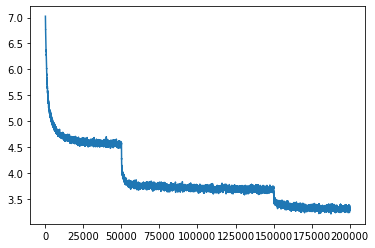

In [9]:
plt.plot(smooth(losses,50))
print("Précision (test) : %f" % accuracy(net, data['test']))

### Tester à partir d'une sauvegarde

On peut aussi tester la version du modèle associée à chaque sauvegarde effectuée pour chaque époque.

Précision (test) : 0.181940


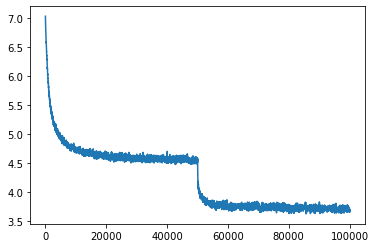

In [10]:
# Tester une sauvegarde
net = Darknet64()
state = torch.load(checkpoints + 'checkpoint-10.pkl')
net.load_state_dict(state['net'])
plt.plot(smooth(state['losses'],50))
print("Précision (test) : %f" % accuracy(net, data['test']))

## Transfert d'apprentissage depuis CIFAR-10

On peut maintenant utiliser nos paramètres préentraîner et les utiliser en tant que préentraînement pour l'ensemble de données CIFAR-10.

### Chargement des données CIFAR

In [11]:
def get_cifar10_data(augmentation=0):
    # Transformations pour l'augmentation des données. (ne pas utiliser pour les tests)
    if augmentation:
        transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4, padding_mode='edge'), # Rognage d'une région 32x32 dans une image 40x40 (après padding)
          transforms.RandomHorizontalFlip(),    # Réflexion de l'image par rapport à l'axe Y 50% du temps
          transforms.ToTensor(),
        ])
    else: 
        transform_train = transforms.ToTensor()

    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                          transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,
                                              num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                        transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False,
                                            num_workers=2)
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return {'train': trainloader, 'test': testloader, 'classes': classes}

cifar_data = get_cifar10_data(augmentation=1)

Files already downloaded and verified
Files already downloaded and verified


### Définition du modèle

Le modèle est le même que pour le modèle ImageNet, à l'exception de la dernière couche entièrement connectée qui n'a que 10 sorties plutôt que 1000.

In [12]:
class Darknet64Cifar(nn.Module):
    def __init__(self):
        super(Darknet64Cifar, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc10 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1)
        x = self.fc10(x)
        return x

### Entraînement à partir de zéro

On peut entraîner ce modèle à partir de zéro, ce qui nous permet d'obtenir une performance de base (*baseline*). Tout comme pour le dernier tutoriel, on obtient une précision d'environ 80%.

Taux d'apprentissage : 0.010000
[0,   100] Perte: 1.680
[0,   200] Perte: 1.424
[0,   300] Perte: 1.322
[1,   100] Perte: 1.137
[1,   200] Perte: 1.084
[1,   300] Perte: 1.055
[2,   100] Perte: 0.961
[2,   200] Perte: 0.948
[2,   300] Perte: 0.931
[3,   100] Perte: 0.865
[3,   200] Perte: 0.849
[3,   300] Perte: 0.828
[4,   100] Perte: 0.790
[4,   200] Perte: 0.792
[4,   300] Perte: 0.769
Taux d'apprentissage : 0.001000
[5,   100] Perte: 0.676
[5,   200] Perte: 0.652
[5,   300] Perte: 0.642
[6,   100] Perte: 0.636
[6,   200] Perte: 0.620
[6,   300] Perte: 0.614
[7,   100] Perte: 0.615
[7,   200] Perte: 0.619
[7,   300] Perte: 0.606
[8,   100] Perte: 0.602
[8,   200] Perte: 0.605
[8,   300] Perte: 0.598
[9,   100] Perte: 0.594
[9,   200] Perte: 0.602
[9,   300] Perte: 0.586
Taux d'apprentissage : 0.000100
[10,   100] Perte: 0.585
[10,   200] Perte: 0.577
[10,   300] Perte: 0.584
[11,   100] Perte: 0.569
[11,   200] Perte: 0.587
[11,   300] Perte: 0.563
[12,   100] Perte: 0.574
[12,   20

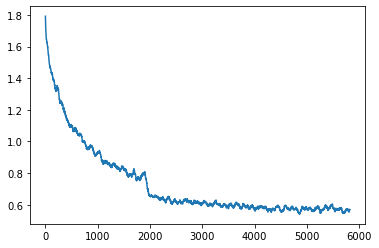

In [13]:
cifar_net = Darknet64Cifar()
cifar_losses = train(cifar_net, cifar_data['train'], epochs=15, schedule={0:.01, 5:.001, 10:.0001}, print_every=100)
print("Précision (test) : %f" % accuracy(cifar_net, cifar_data['test']))
plt.plot(smooth(cifar_losses,50))

### Entraîner avec des paramètres préentraînés.

On peut initialiser le modèle avec les poids de la dernière sauvegarde de l'entraînement sur ImageNet. Les couches de convolution seront ainsi initialisée comme un extracteur de caractéristiques puissant, et la couche entièrement connectée sera initialisée avec des valeurs aléatoires.

En utilisant la même stratégie d'entraînement que pour le modèle précédent, le modèle atteindra une précision significativement plus élevée.

In [14]:
pretrain_net = Darknet64Cifar()

# Chargement des poids depuis le modèle ImageNet préentraîné.
state = torch.load(checkpoints + 'checkpoint-20.pkl')
output = pretrain_net.load_state_dict(state['net'], strict=False)


Taux d'apprentissage : 0.010000
[0,   100] Perte: 1.034
[0,   200] Perte: 0.790
[0,   300] Perte: 0.758
[1,   100] Perte: 0.657
[1,   200] Perte: 0.648
[1,   300] Perte: 0.651
[2,   100] Perte: 0.586
[2,   200] Perte: 0.603
[2,   300] Perte: 0.585
[3,   100] Perte: 0.536
[3,   200] Perte: 0.566
[3,   300] Perte: 0.555
[4,   100] Perte: 0.512
[4,   200] Perte: 0.538
[4,   300] Perte: 0.544
Taux d'apprentissage : 0.001000
[5,   100] Perte: 0.445
[5,   200] Perte: 0.431
[5,   300] Perte: 0.409
[6,   100] Perte: 0.394
[6,   200] Perte: 0.400
[6,   300] Perte: 0.387
[7,   100] Perte: 0.387
[7,   200] Perte: 0.391
[7,   300] Perte: 0.388
[8,   100] Perte: 0.381
[8,   200] Perte: 0.393
[8,   300] Perte: 0.381
[9,   100] Perte: 0.364
[9,   200] Perte: 0.363
[9,   300] Perte: 0.372
Taux d'apprentissage : 0.000100
[10,   100] Perte: 0.358
[10,   200] Perte: 0.358
[10,   300] Perte: 0.339
[11,   100] Perte: 0.353
[11,   200] Perte: 0.353
[11,   300] Perte: 0.369
[12,   100] Perte: 0.351
[12,   20

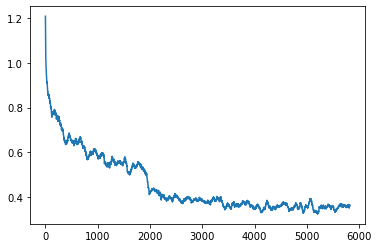

In [15]:
pretrain_net = Darknet64Cifar()

# Chargement des poids depuis le modèle ImageNet préentraîné.
state = torch.load(checkpoints + 'checkpoint-20.pkl')
pretrain_net.load_state_dict(state['net'], strict=False)
# `strict=false` indique à PyTorch qu'il faut ignorer les différences entre le réseau enregistré et le réseau de destination

# Entraînement de la même façon que plus haut (c.-à-d. CIFAR à partir de zéro.)
pretrain_losses = train(pretrain_net, cifar_data['train'], epochs=15, schedule={0:.01, 5:.001, 10:.0001}, print_every=100)
print("Précision (test) : %f" % accuracy(pretrain_net, cifar_data['test']))
plt.plot(smooth(pretrain_losses,50))

### Comparaison de l'apprentissage à partir de zéro vs préentraînement

Le modèle préentraîné converge beaucoup plus rapidement vers un poids final plus bas et vers une meilleure précision. Vous pouvez essayer plusierus paramètres d'apprentissage pour tenter d'obtenir des meilleurs résultats!

Le préentraînement est une technique puissante, car on peut ainsi apprendre beaucoup plus rapidement sur un nouveau jeu de données. Ceci signifie que vous n'avaez pas à entraîner vos modèles aussi longtemps, ce qui rend plus facile l'entraînement d'un classificateur et rends donc moins probablement le sur-ajustement des données.

En général, vous pouvez utiliser des taux d'apprentissage plus petit lorsqu'on fait un ajustement fin (*fine-tuning*) sur un nouvel ensemble de données, ce qui aide avec le sur-ajustement. Toutefois, chaque jeu de données est différent, il faut donc jouer un peu avec les hyper-paramètres pour voir ce qui fonctionne le mieux pour chaque application.

Précision (test) pour l'entraînement à partir de zéro : 0.797300
Précision (test) pour le préentraînement : 0.854000


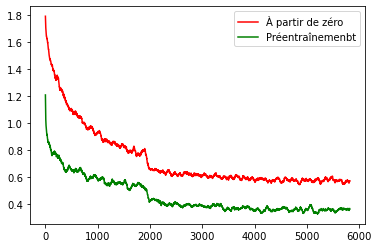

In [16]:
print("Précision (test) pour l'entraînement à partir de zéro : %f" % accuracy(cifar_net, cifar_data['test']))
print("Précision (test) pour le préentraînement : %f" % accuracy(pretrain_net, cifar_data['test']))

plt.plot(smooth(cifar_losses,50), 'r-', label="À partir de zéro")
plt.plot(smooth(pretrain_losses,50),'g-', label="Préentraînemenbt")
plt.legend()

## Transfert d'apprentissage avec Resnet

En pratique, on entraînement pas nos modèles nous même sur ImageNet. On prèfère télécharger des modèles préentraîné. PyTorch fournit plusieurs modèles intégrés !

In [17]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
print(model)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /home/joel/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/joel/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
52.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Un ensemble de données "plus grand"

Il y a un problème avec ResNet, c'est qu'il s'attend à recevoir des images beaucoup plus grande que celle fourni par CIFAR. Pour remédier à ce problème, nous allons redimensionner notre ensemble de donneés ...

Pour la plupart des jeux de données, il ne sera pas nécessaire de faice ces opérations. Vous devrez toutefois vous assurer que votre jeu de données est défini de telle sorte que vous traitez les images avec un taille suffisante pour le modèle utilisé. Pour resnet18, des images de taille 128x128 devrait être suffisement grande.

In [18]:
def get_big_cifar10_data(augmentation=0):
    # Transformations pour l'augmentation des données. (Ne pas utiliser pour les tests)
    if augmentation:
        transform_train = transforms.Compose([
          transforms.Resize(128),
          transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Rogner une région 128x128 à partir d'une image 136x136 (avec un padding)
          transforms.RandomHorizontalFlip(),    # Réflexion par rapport à l'axe y (50% du temps)
          transforms.ToTensor(),
        ])
    else: 
        transform_train = transforms.ToTensor()

    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                          transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,
                                              num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                        transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False,
                                            num_workers=2)
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return {'train': trainloader, 'test': testloader, 'classes': classes}


### Ajustement fin de ResNet sur Cifar agrandi

On peut maintenant charger nos données et le modèle, réinitialiser la dernière couche du modèle pour obtenir 10 préditions en sortie plutôt que 1000, et l'entraîner !

Files already downloaded and verified
Files already downloaded and verified


Using cache found in /home/joel/.cache/torch/hub/pytorch_vision_v0.6.0


[0,   100] Perte: 0.642
[0,   200] Perte: 0.348
[0,   300] Perte: 0.286
Précision (test) : 0.913000


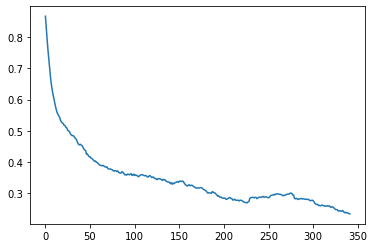

In [19]:
big_cifar_data = get_big_cifar10_data(augmentation=1)
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
# Avant, la dernière couche était resnet.fc = nn.Linear(512, 1000)
resnet.fc = nn.Linear(512, 10) # Réinitialise la dernièr couche, et lui assigne des poids alétaoires

resnet_losses = train(resnet, big_cifar_data['train'], epochs=1, lr=.01, print_every=100)
print("Précision (test) : %f" % accuracy(resnet, big_cifar_data['test']))
plt.plot(smooth(resnet_losses, 50))

C'est une succès ! Après seulement 1 époque d'entraînement ResNet18 obtient presque 91% de précision (test) sur CIFAR10. Par contre, l'entraînement prend beaucoup plus de temps, car le modèle est très grand et on a augmenté la taille de l'ensemble de données (de 32x32 à 128x128).

Files already downloaded and verified
Files already downloaded and verified


Using cache found in /home/joel/.cache/torch/hub/pytorch_vision_v0.6.0


[0,   100] Perte: 0.657
[0,   200] Perte: 0.342
[0,   300] Perte: 0.316
[1,   100] Perte: 0.202
[1,   200] Perte: 0.181
[1,   300] Perte: 0.196
[2,   100] Perte: 0.136
[2,   200] Perte: 0.128
[2,   300] Perte: 0.146
[3,   100] Perte: 0.111
[3,   200] Perte: 0.109
[3,   300] Perte: 0.116
[4,   100] Perte: 0.084
[4,   200] Perte: 0.085
[4,   300] Perte: 0.084
[5,   100] Perte: 0.066
[5,   200] Perte: 0.074
[5,   300] Perte: 0.091
[6,   100] Perte: 0.062
[6,   200] Perte: 0.065
[6,   300] Perte: 0.075
[7,   100] Perte: 0.060
[7,   200] Perte: 0.054
[7,   300] Perte: 0.062
[8,   100] Perte: 0.055
[8,   200] Perte: 0.050
[8,   300] Perte: 0.058
[9,   100] Perte: 0.046
[9,   200] Perte: 0.043
[9,   300] Perte: 0.051
Précision (test) : 0.927600


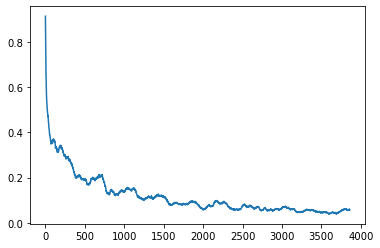

In [20]:
big_cifar_data = get_big_cifar10_data(augmentation=1)
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
# Avant la dernière couche était resnet.fc = nn.Linear(512, 1000)
resnet.fc = nn.Linear(512, 10) # Réinitialise la dernièr couche, et lui assigne des poids alétaoires

resnet_losses = train(resnet, big_cifar_data['train'], epochs=10, lr=.01, print_every=100)
print("Précision (test) : %f" % accuracy(resnet, big_cifar_data['test']))
plt.plot(smooth(resnet_losses, 50))